In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from ripple_heterogeneity.utils import (
    functions,
    loading,
    batch_analysis,
    compress_repeated_epochs,
)
from ripple_heterogeneity.place_cells import place_cells_run, fields, maps
import statistics
import nelpy as nel
from scipy.ndimage import gaussian_filter
from scipy.ndimage import rotate
import pickle
import glob
from skimage import measure



<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
functions.set_plotting_defaults()

%config InlineBackend.figure_format = 'retina'

fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

In [4]:
# basepath = r"Z:\\Data\\Kenji\\ec013.656_674"
# results = place_cells_run.run(basepath, n_shuff=20)


In [5]:
results.keys()


dict_keys(['df', 'ratemaps', 'occupancies', 'x', 'y', 'ts', 'st'])

In [34]:
# basepath = r"Z:\\Data\\Kenji\\ec013.656_674"
basepath = r"Z:\\Data\\Kenji\\ec013.702_724"

# load position
position_df = loading.load_animal_behavior(basepath)
position_df_no_nan = position_df.query("not x.isnull() & not y.isnull()")

st,cm = loading.load_spikes(basepath,putativeCellType="Pyr",brainRegion="CA1")

pos = nel.PositionArray(
    data=position_df_no_nan[["x", "y"]].values.T,
    timestamps=position_df_no_nan.timestamps.values,
)
epoch_df = loading.load_epoch(basepath)
epochs = nel.EpochArray(np.array([epoch_df.startTime,epoch_df.stopTime]).T)

# tc = maps.SpatialMap(pos[epochs[4]],st[epochs[4]],dim=2)

In [35]:
epoch_df

name   startTime    stopTime environment  \
0       ec013.702_sleep      0.0000    413.2864       sleep   
1       ec013.703_sleep    413.2864   2883.9934       sleep   
2       ec013.704_sleep   2883.9934   6404.8934       sleep   
3      ec013.705_Mwheel   6404.8934   8605.2644      Mwheel   
4       ec013.706_sleep   8605.2644  10697.0914       sleep   
5       ec013.707_sleep  10697.0914  10829.3922       sleep   
6       ec013.708_sleep  10829.3922  12029.7922       sleep   
7       ec013.709_sleep  12029.7922  13225.4142       sleep   
8       ec013.710_sleep  13225.4142  14393.4142       sleep   
9       ec013.711_sleep  14393.4142  14868.1406       sleep   
10      ec013.712_sleep  14868.1406  18187.2406       sleep   
11  ec013.713_bigSquare  18187.2406  20457.6536   bigSquare   
12  ec013.714_bigSquare  20457.6536  22735.7536   bigSquare   
13      ec013.715_wheel  22735.7536  23680.2912       wheel   
14      ec013.717_wheel  23680.2912  24799.3182       wheel   
15     ec013.718_linear  24799.3182  25989.2062      linear   
16     ec013.719_linear  25989.2062  27191.3822      linear   
17     ec013.720_linear  27191.3822  28570.9152      linear   
18      ec013.722_sleep  28570.9152  29059.9776       sleep   
19      ec013.723_sleep  29059.9776  29160.4776       sleep   
20      ec013.724_sleep  29160.4776  29829.6776       sleep   

    behavioralParadigm  
0                   10  
1                   10  
2                   10  
3                   10  
4                   10  
5                   10  
6                   10  
7                   10  
8                   10  
9                   10  
10                  10  
11                  10  
12                  10  
13                  10  
14                  10  
15                  10  
16                  10  
17                  10  
18                  10  
19                  10  
20                  10

In [137]:
pos[epochs[15]], st[epochs[15]]

(<PositionArray at 0x26969c88820: 2 signals (6 segments)> for a total of 19:01:478 minutes,
 <SpikeTrainArray at 0x26971ca7670: 23 units> at 20000 Hz)

In [134]:
spatial_maps = maps.SpatialMap(
    pos[epochs[11]], st[epochs[11]], dim=2, s_binsize=3, tuning_curve_sigma=3
)
spatial_maps.find_fields()


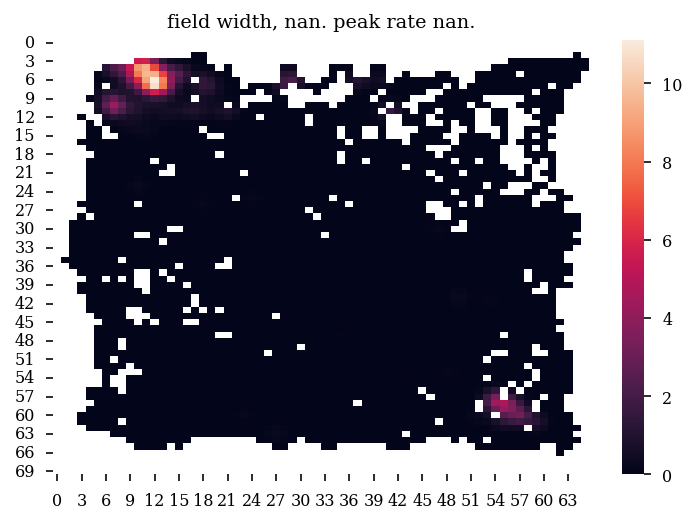

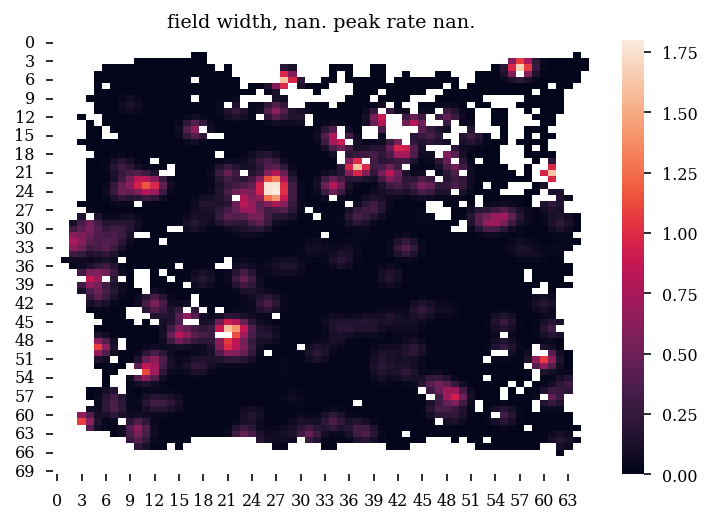

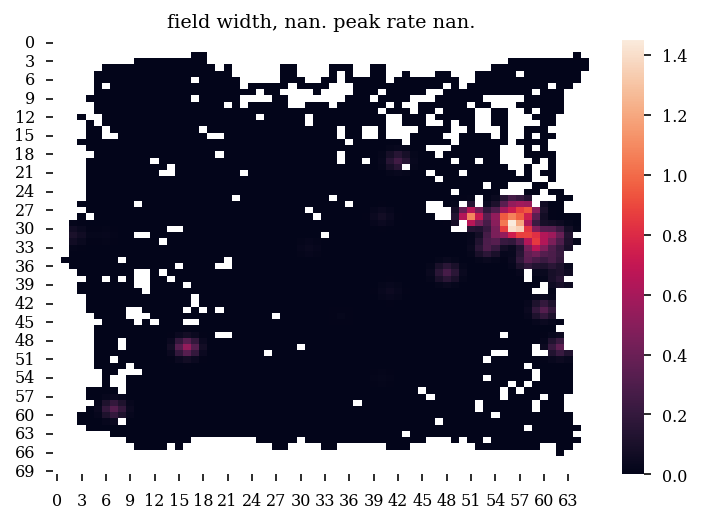

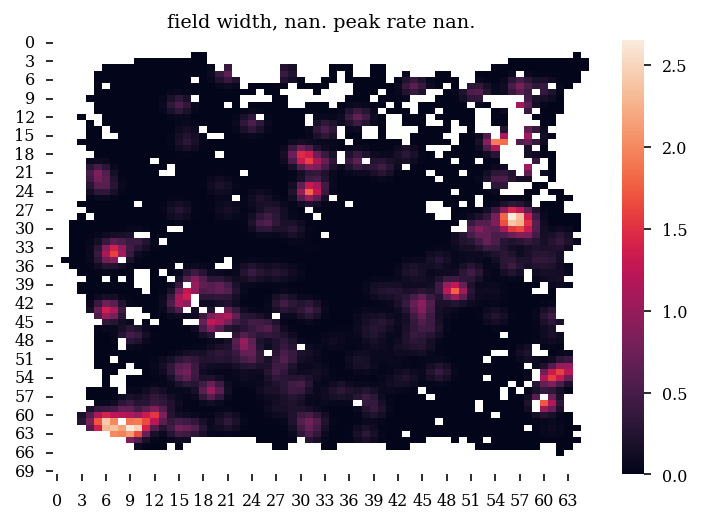

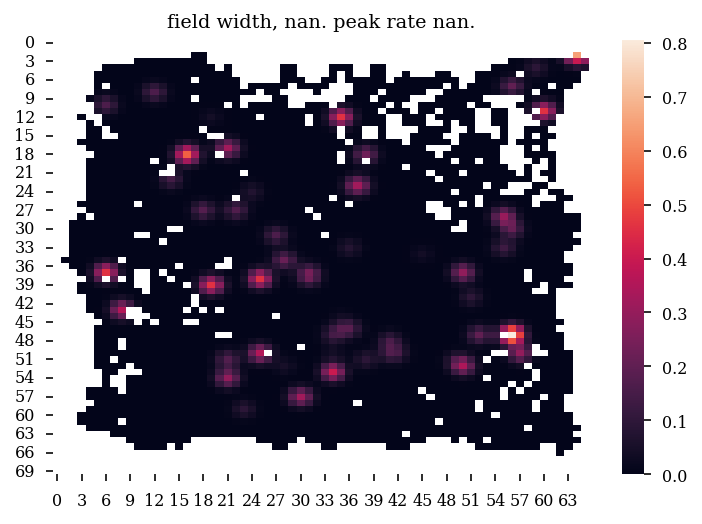

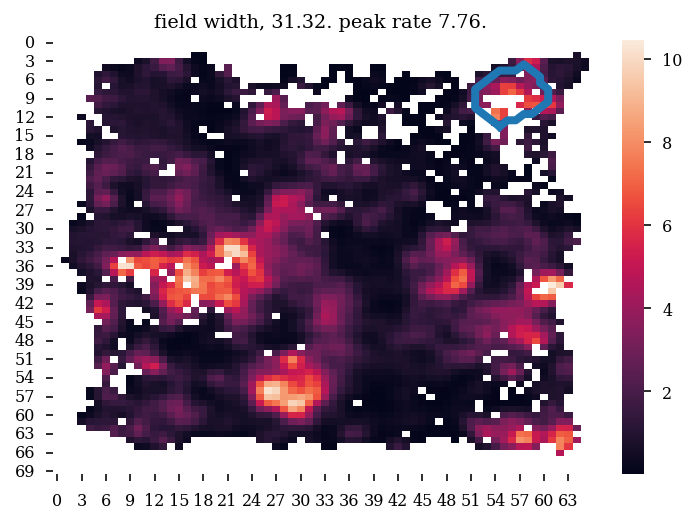

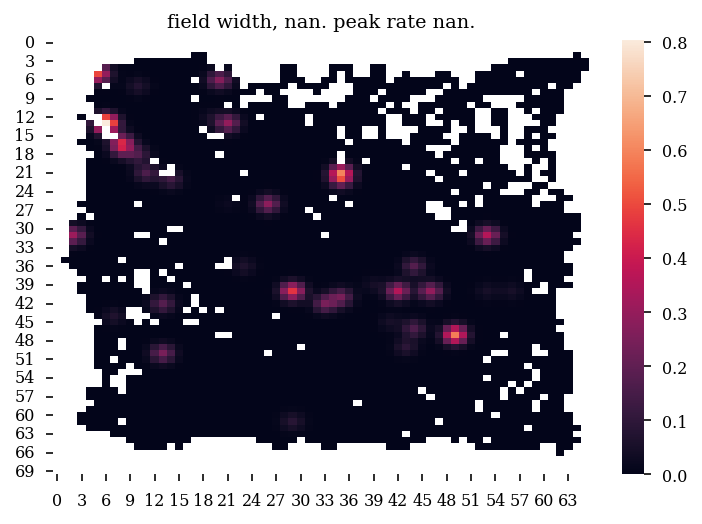

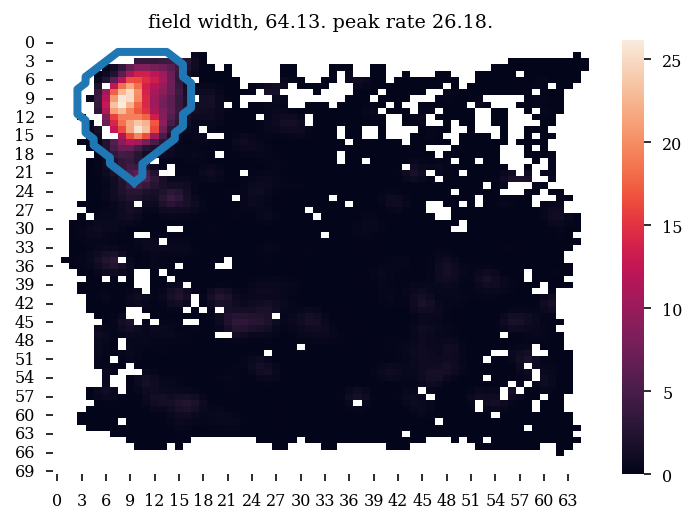

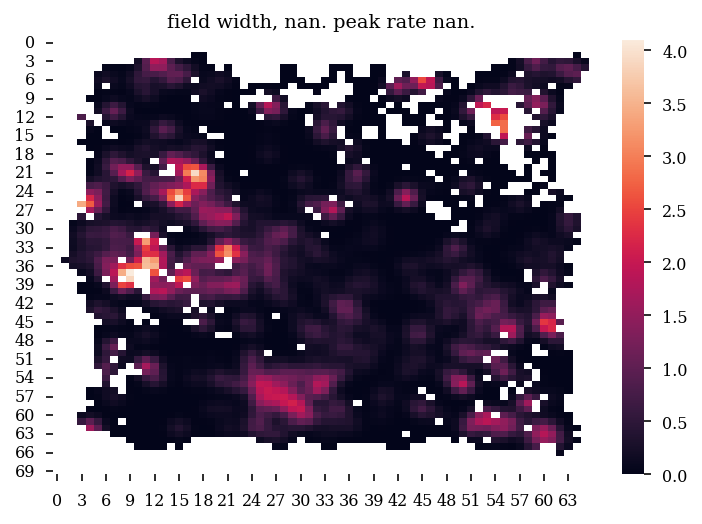

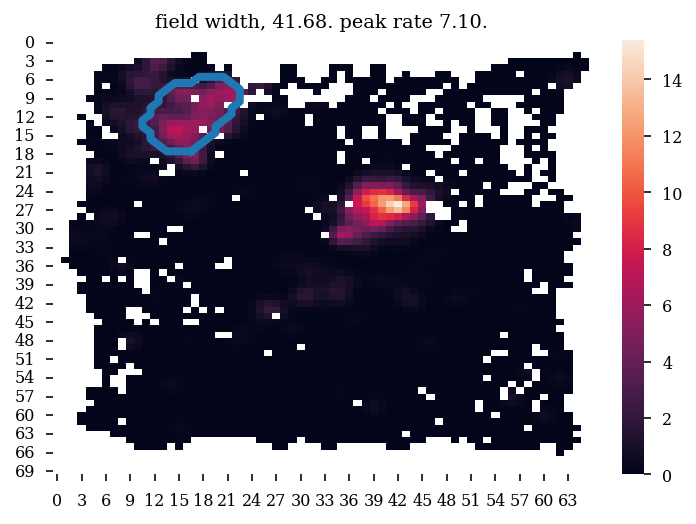

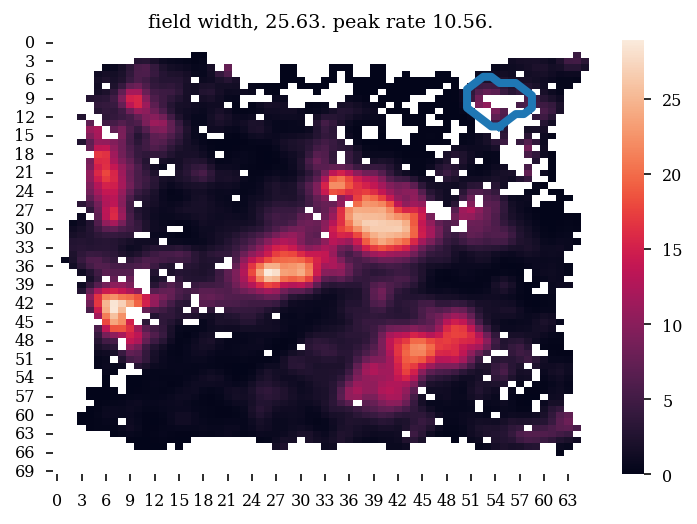

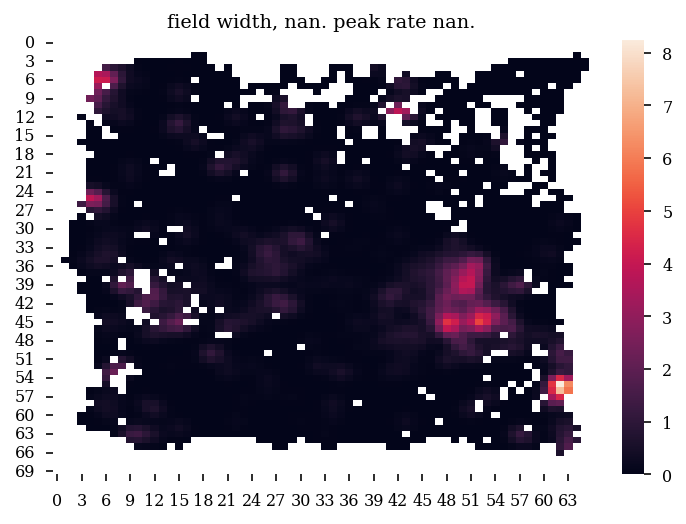

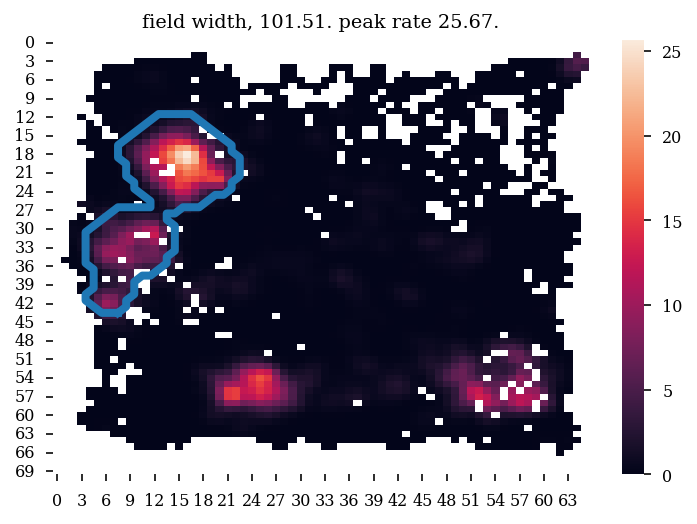

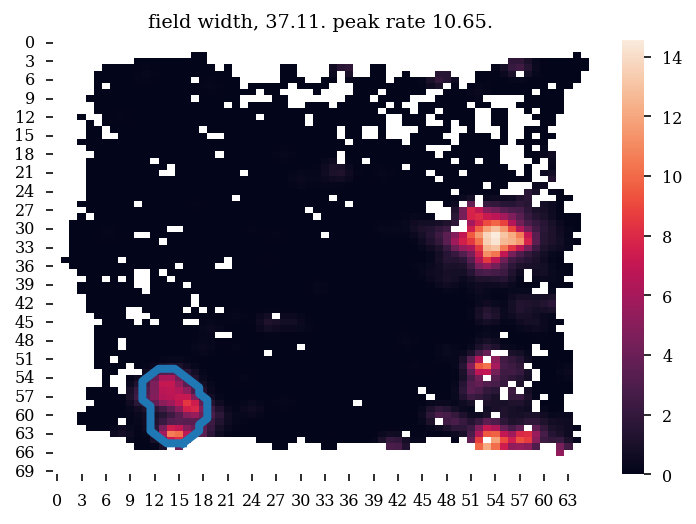

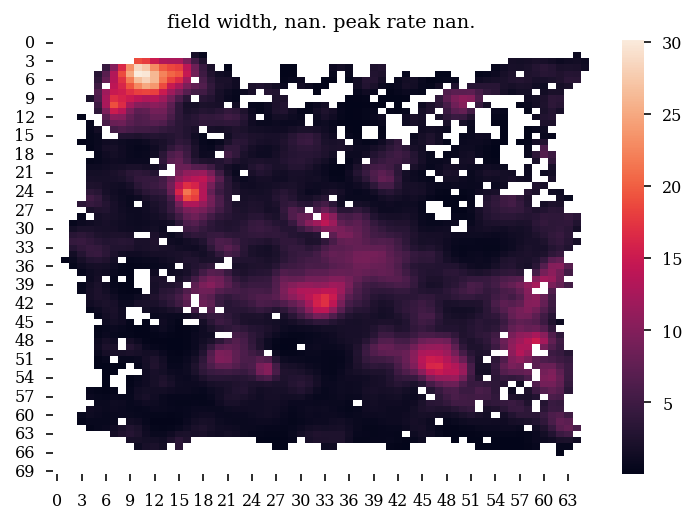

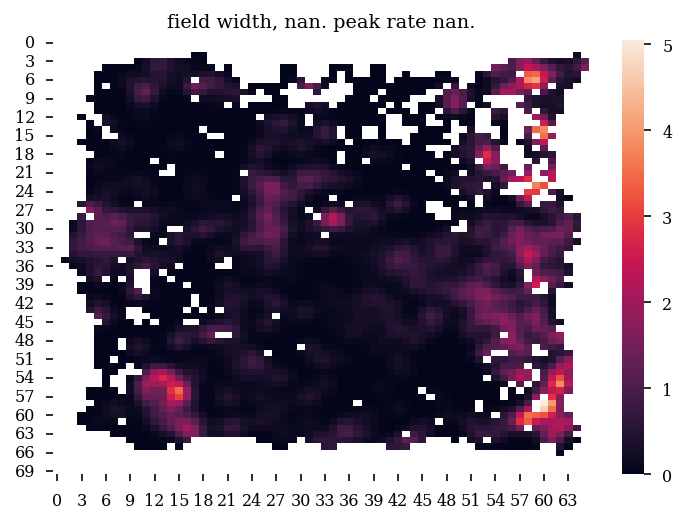

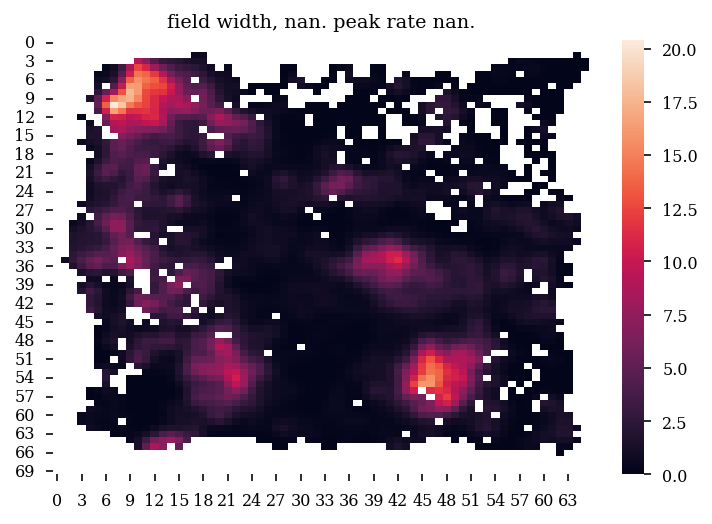

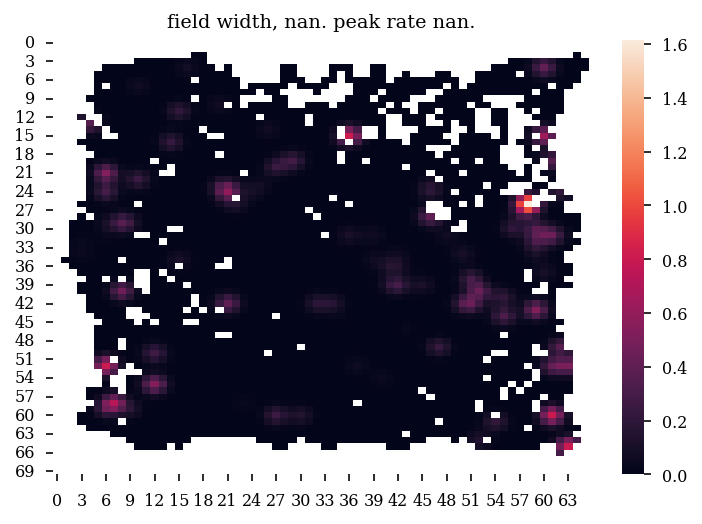

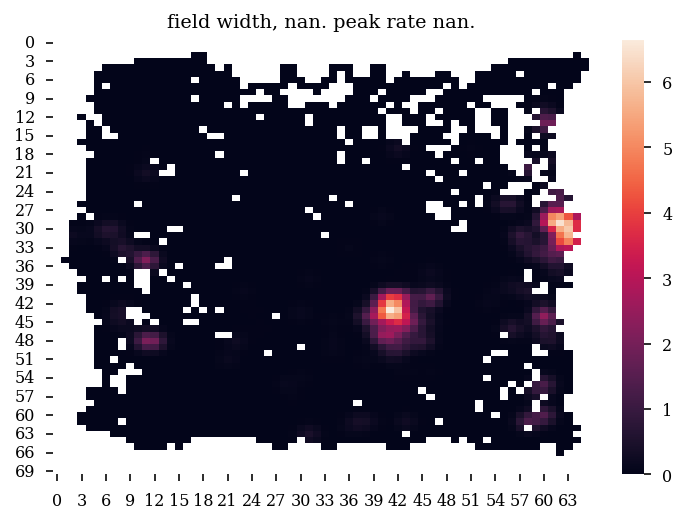

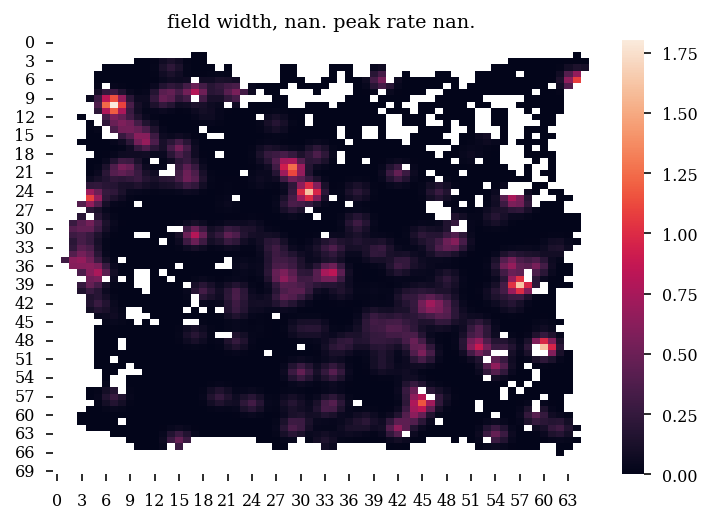

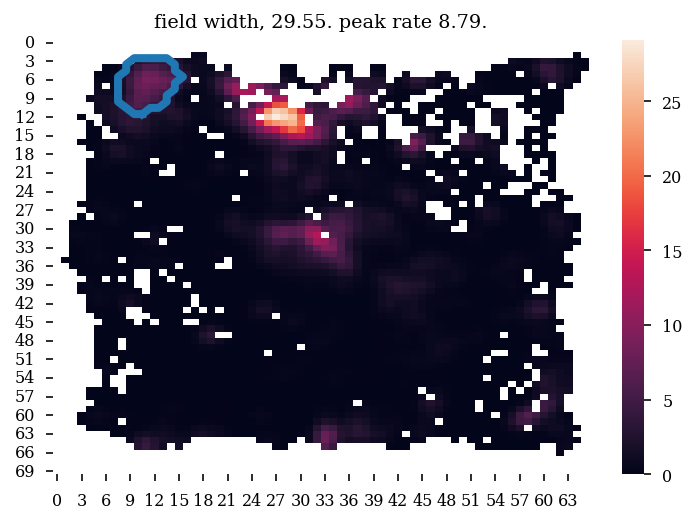

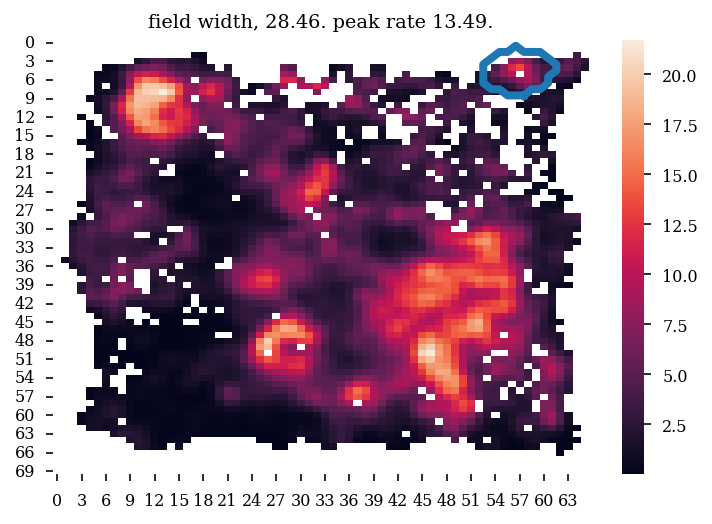

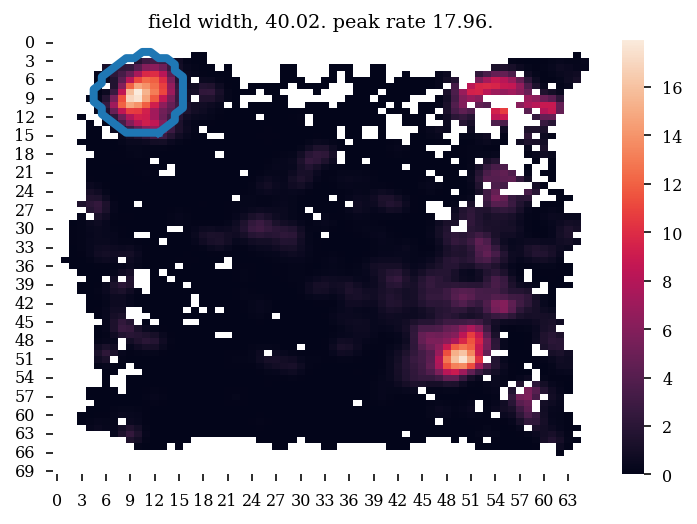

In [136]:
for ratemap_i, ratemap__ in enumerate(spatial_maps.tc.ratemap):
    ratemap_ = ratemap__.copy()
    ratemap_[spatial_maps.tc.occupancy < 0.01] = np.nan

    sns.heatmap(ratemap_)
    field_ids = np.unique(spatial_maps.tc.field_mask[ratemap_i])
    
    if len(field_ids) > 1:
        bc = measure.find_contours(
            spatial_maps.tc.field_mask[ratemap_i] == np.min(field_ids[field_ids > 0]),
            0,
            fully_connected="low",
            positive_orientation="low",
        )
        for c in bc:
            plt.plot(c[:, 1], c[:, 0], linewidth=4)
    plt.title(
        f"field width, {spatial_maps.tc.field_width[ratemap_i]:.2f}. peak rate {spatial_maps.tc.field_peak_rate[ratemap_i]:.2f}."
    )
    plt.show()


In [138]:
basepath = r"Z:\\Data\\Kenji\\ec013.702_724"

# load position
position_df = loading.load_animal_behavior(basepath)
position_df_no_nan = position_df.query("not x.isnull() & not y.isnull()")

st,cm = loading.load_spikes(basepath,putativeCellType="Pyr",brainRegion="CA1")

pos = nel.PositionArray(
    data=position_df_no_nan[["linearized"]].values.T,
    timestamps=position_df_no_nan.timestamps.values,
)
epoch_df = loading.load_epoch(basepath)
epochs = nel.EpochArray(np.array([epoch_df.startTime,epoch_df.stopTime]).T)

In [140]:
outbound_epochs, inbound_epochs = functions.get_linear_track_lap_epochs(
    pos.abscissa_vals, pos.data[0], newLapThreshold=20
)

In [252]:
spatial_maps = maps.SpatialMap(
    pos[epochs[15]],
    st[epochs[15]],
    dim=1,
    dir_epoch=inbound_epochs,
    place_field_min_size = 15,
    place_field_max_size = None,
    place_field_min_peak = 3,
    place_field_sigma=None,
    place_field_thres=.33
)
spatial_maps.find_fields()

{'sizes': [0.5757575757575758, 0.3838383838383838],
 'peaks': [22.418462134377737, 7.15917153065969],
 'means': [7.745607719039615, 3.0980930440425785],
 'fields': array([0., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.])}

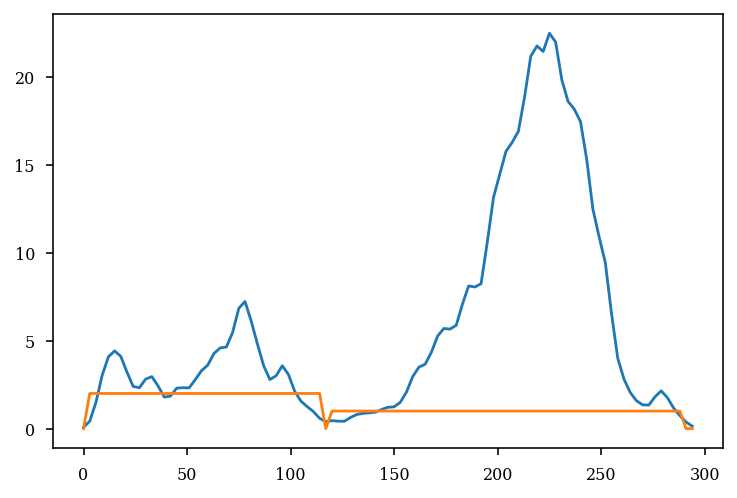

In [249]:
ratemap_ = spatial_maps.tc.ratemap[14]

x = np.arange(len(ratemap_)) * spatial_maps.s_binsize
plt.plot(x,ratemap_)
map_fields = fields.map_stats2(
    ratemap_,
    threshold=.33,
    min_size=spatial_maps.place_field_min_size / spatial_maps.s_binsize,
    max_size=None,
    min_peak=spatial_maps.place_field_min_peak,
    sigma=None,
)
plt.plot(x,map_fields["fields"])
map_fields

In [177]:
spatial_maps.tc.field_width

array([ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
       153.,  nan,  nan,  nan,  nan, 189.,  nan, 153.,  nan,  nan, 150.,
        nan])

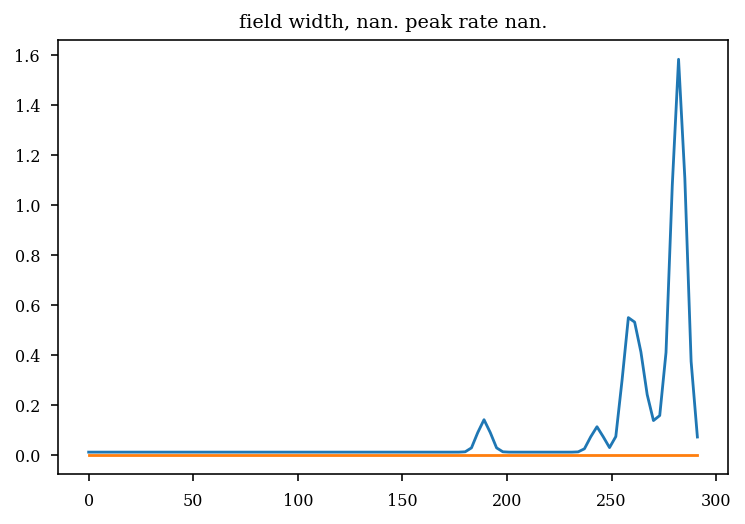

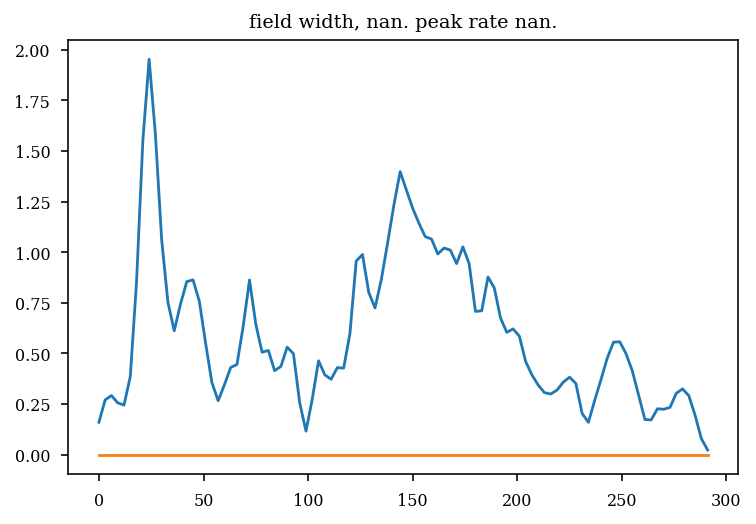

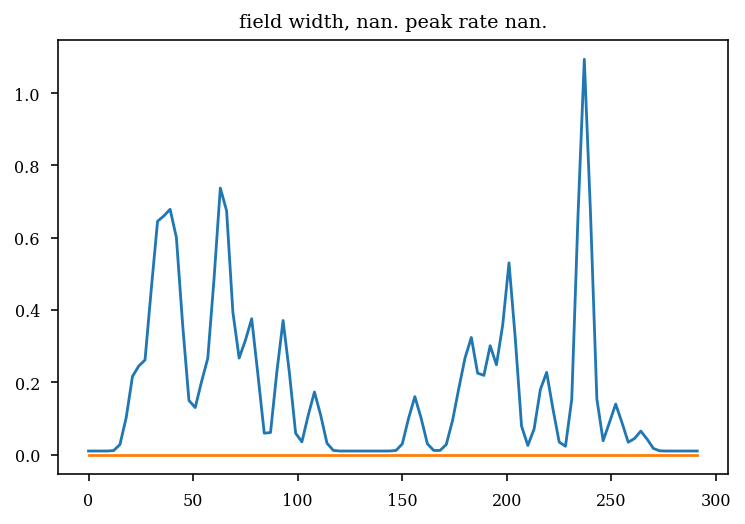

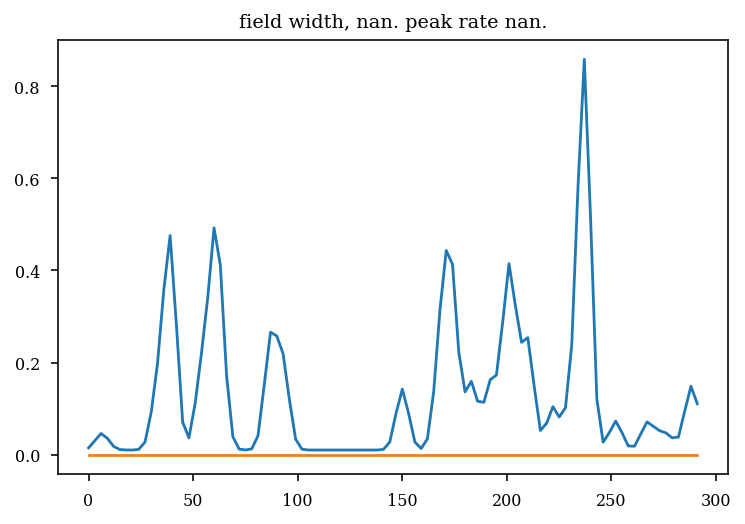

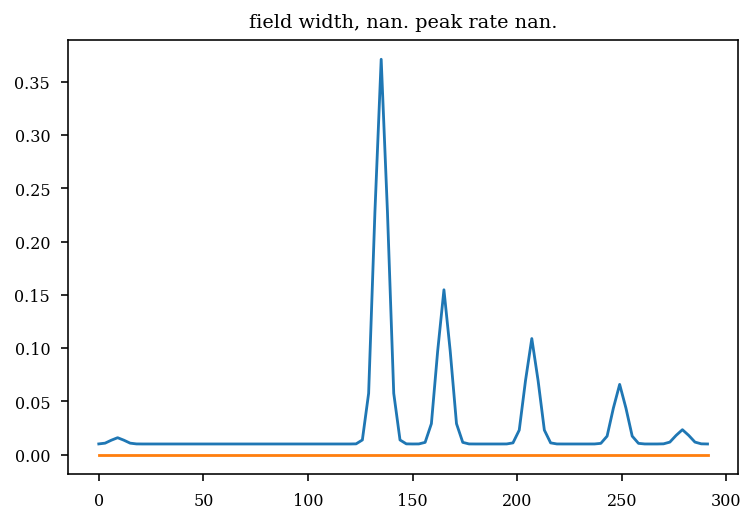

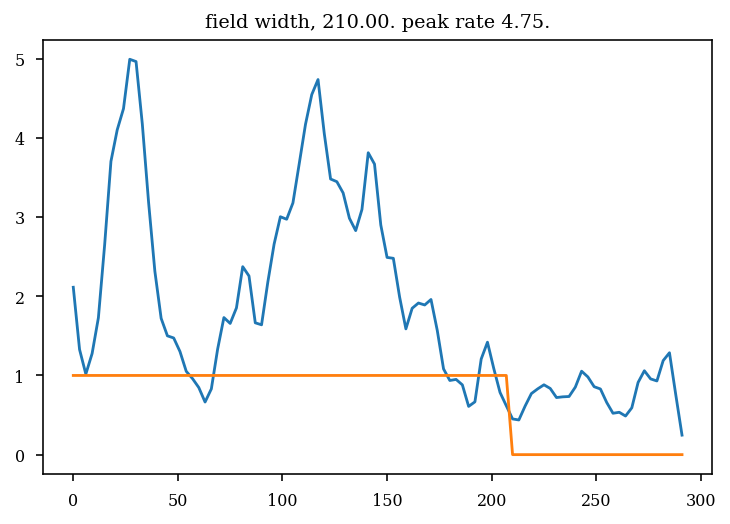

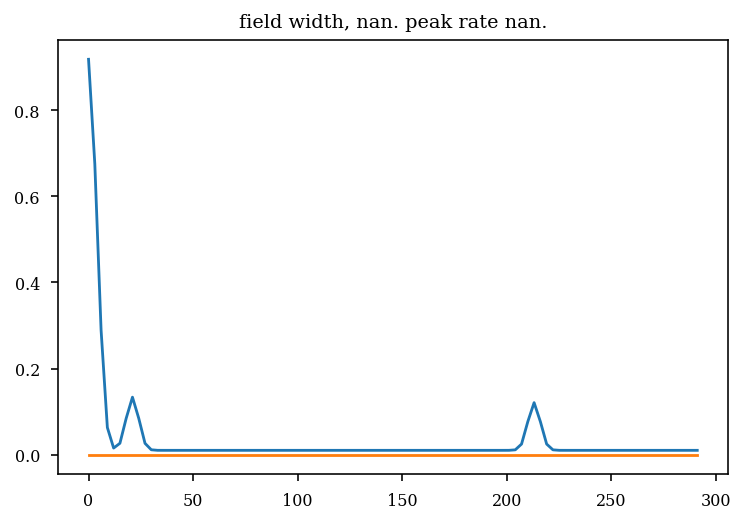

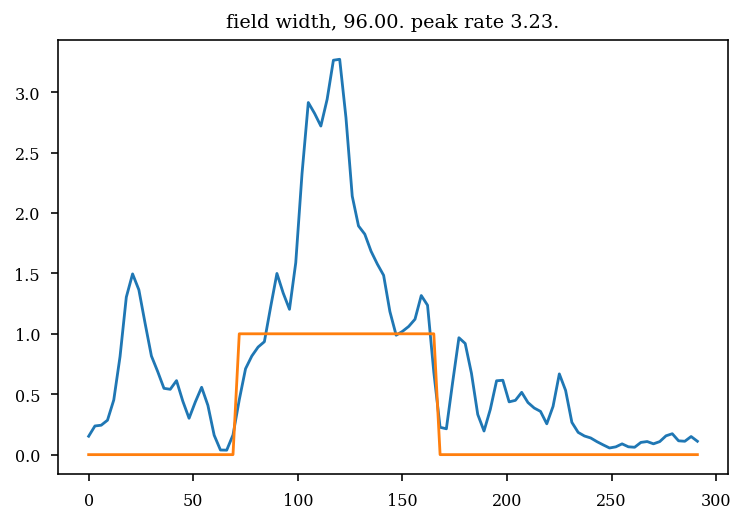

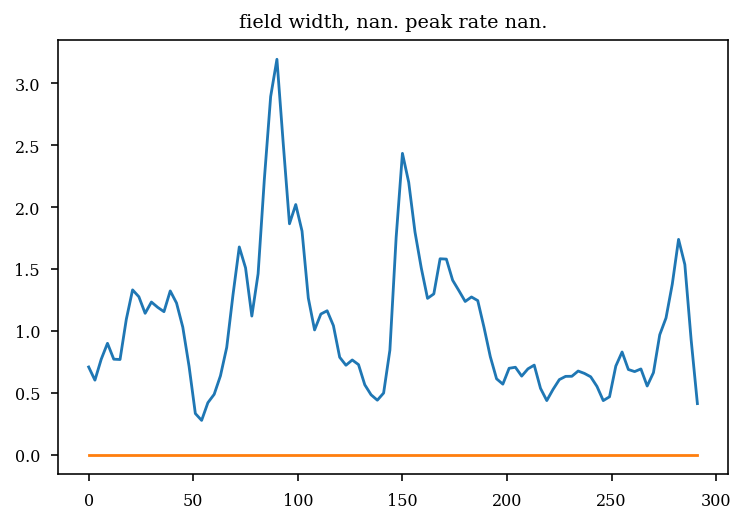

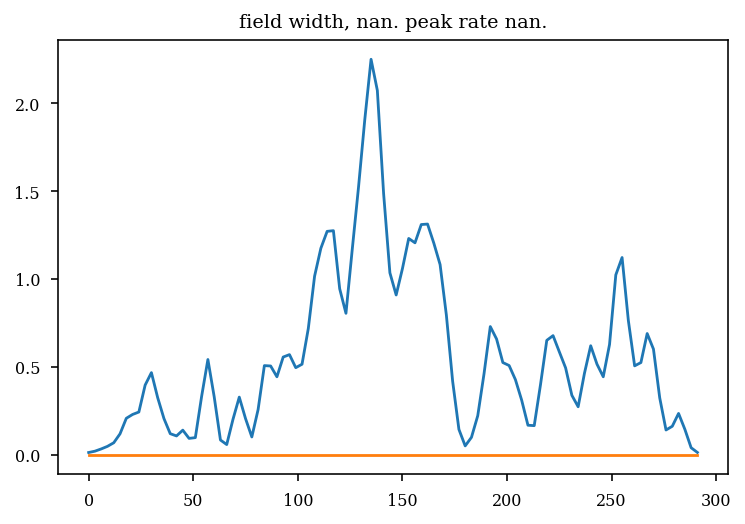

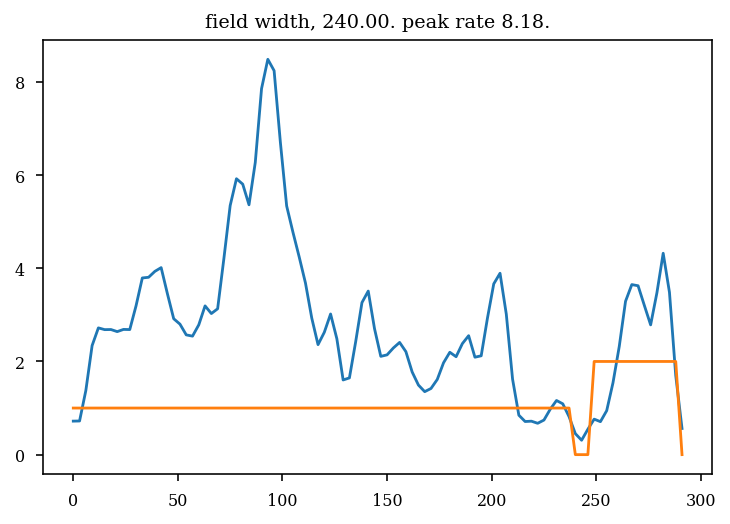

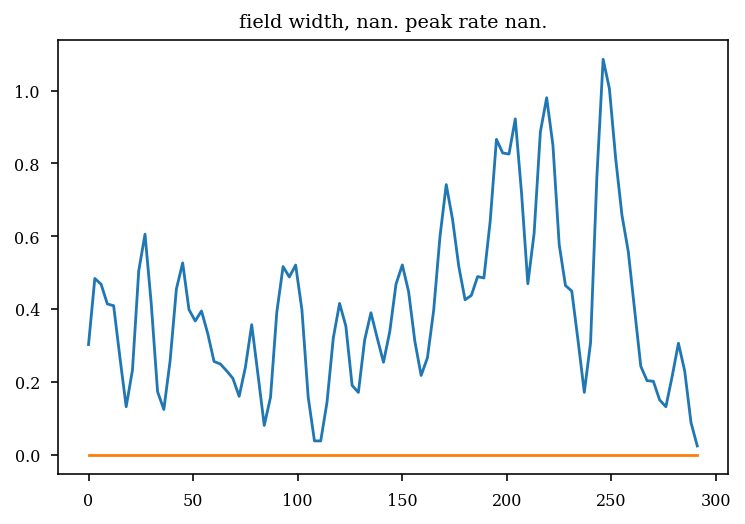

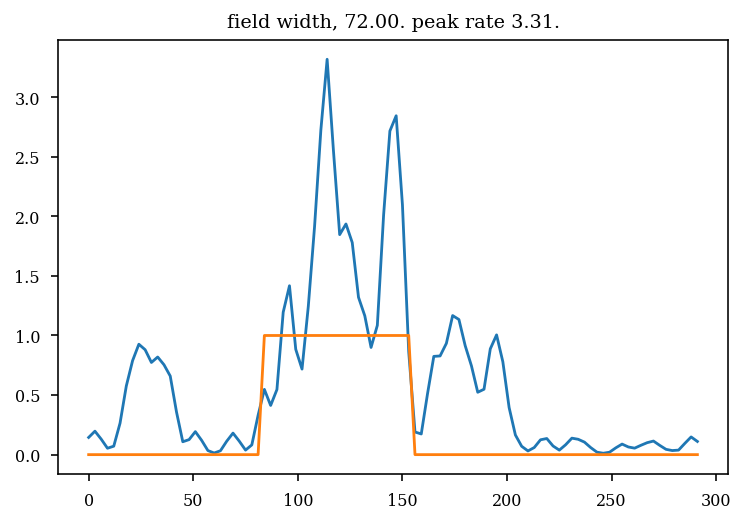

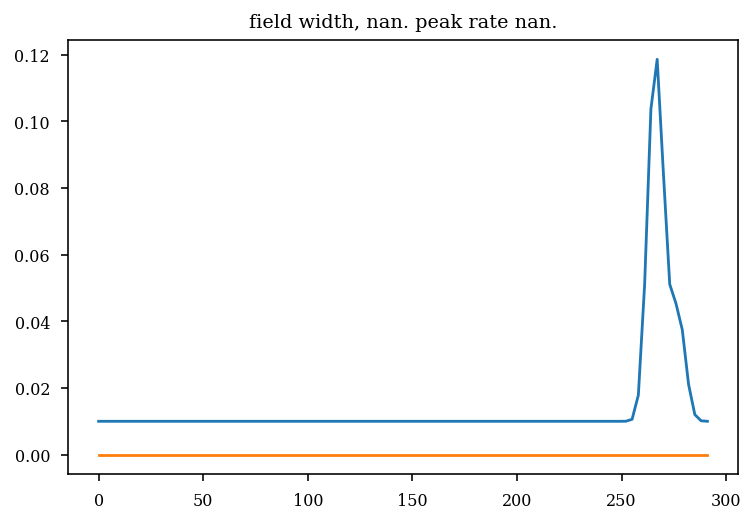

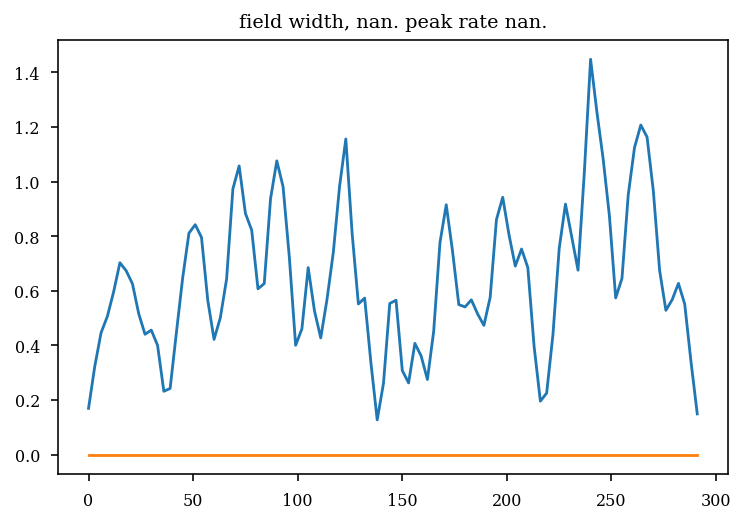

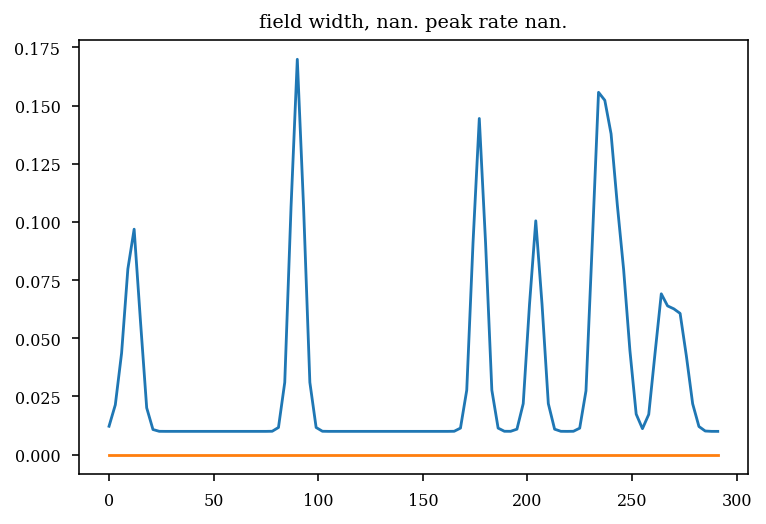

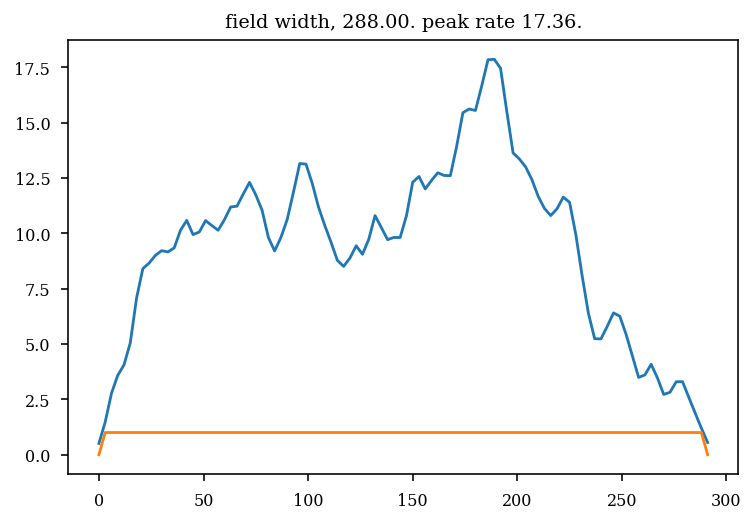

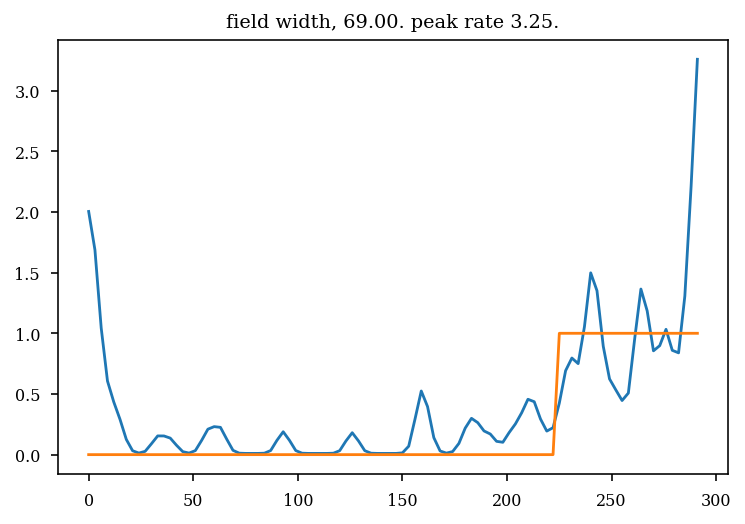

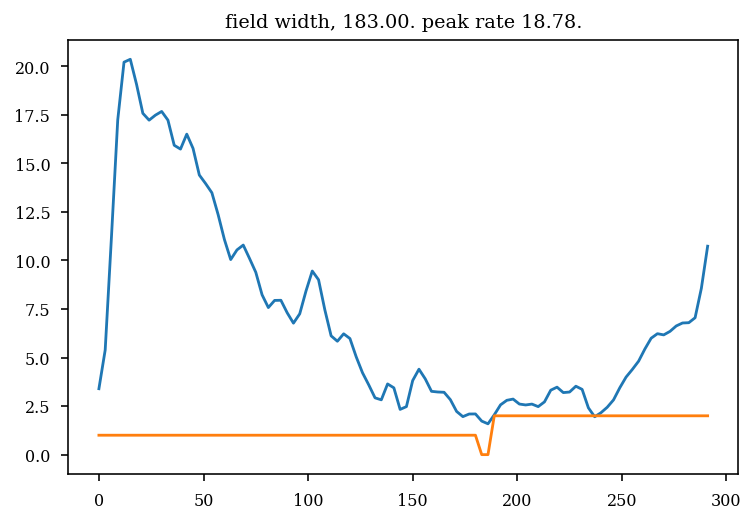

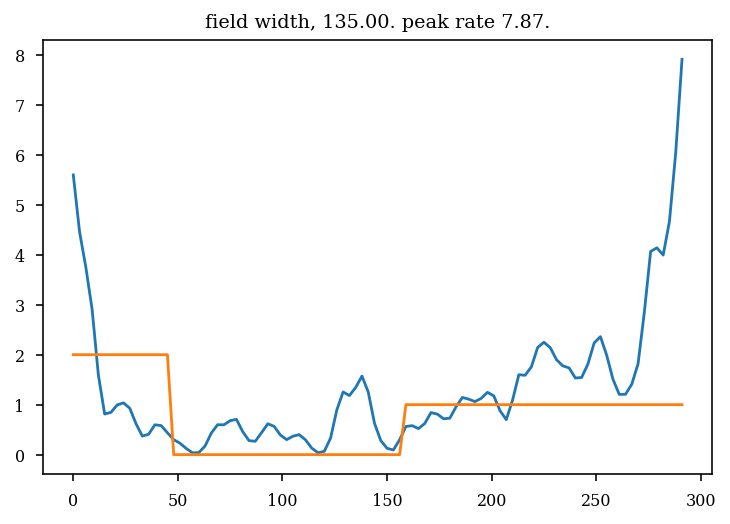

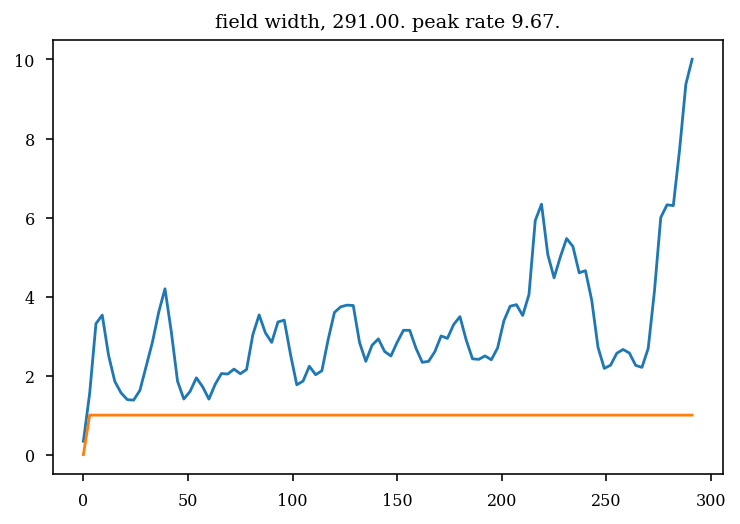

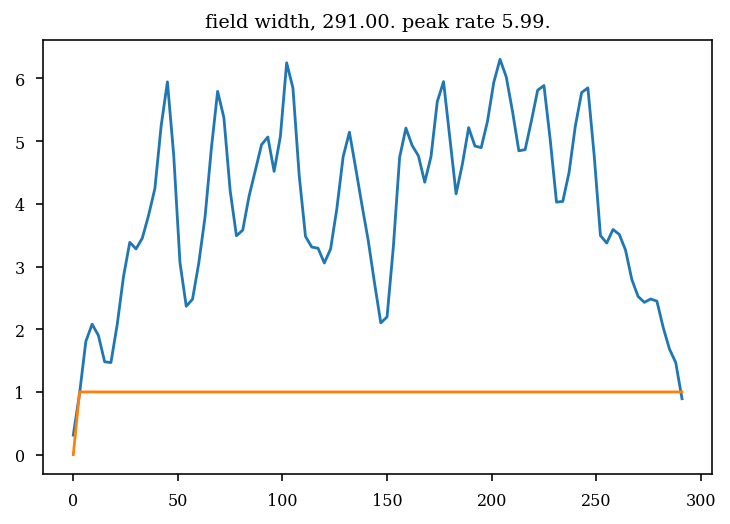

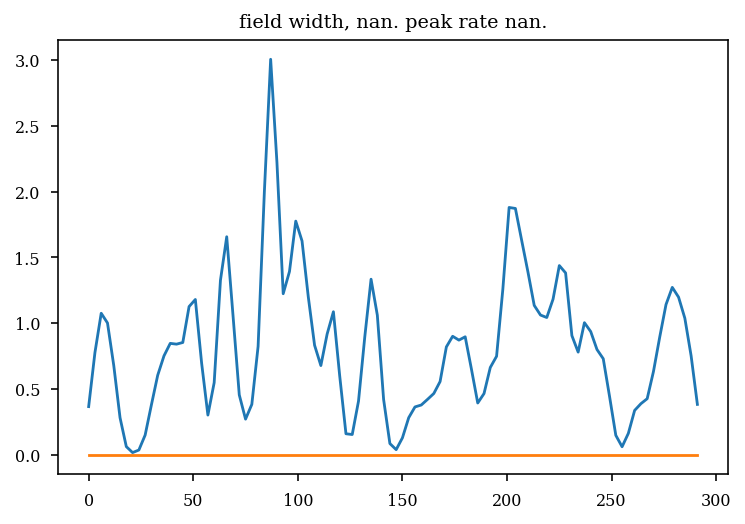

In [253]:
for ratemap_i, ratemap__ in enumerate(spatial_maps.tc.ratemap):
    ratemap_ = ratemap__.copy()
    x = np.arange(len(ratemap_)) * spatial_maps.s_binsize
    plt.plot(x,ratemap_)
    # field_ids = np.unique(spatial_maps.tc.field_mask[ratemap_i])
    plt.plot(x,spatial_maps.tc.field_mask[ratemap_i])
    plt.title(
        f"field width, {spatial_maps.tc.field_width[ratemap_i]:.2f}. peak rate {spatial_maps.tc.field_peak_rate[ratemap_i]:.2f}."
    )
    plt.show()


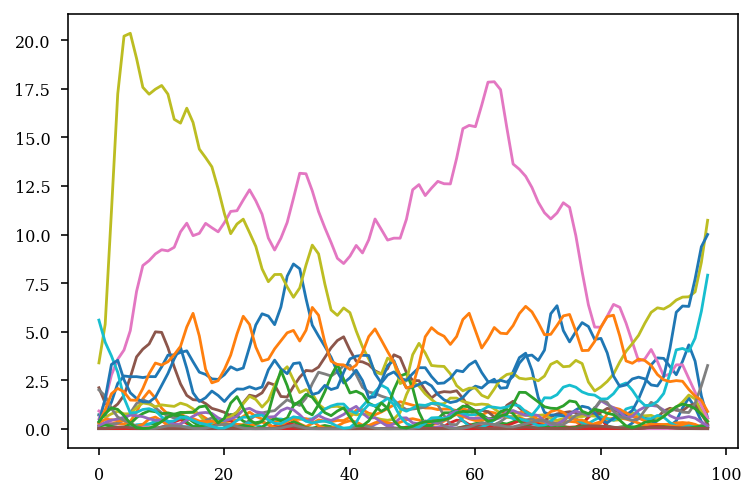

In [254]:
plt.plot(spatial_maps.tc.ratemap.T)
plt.show()

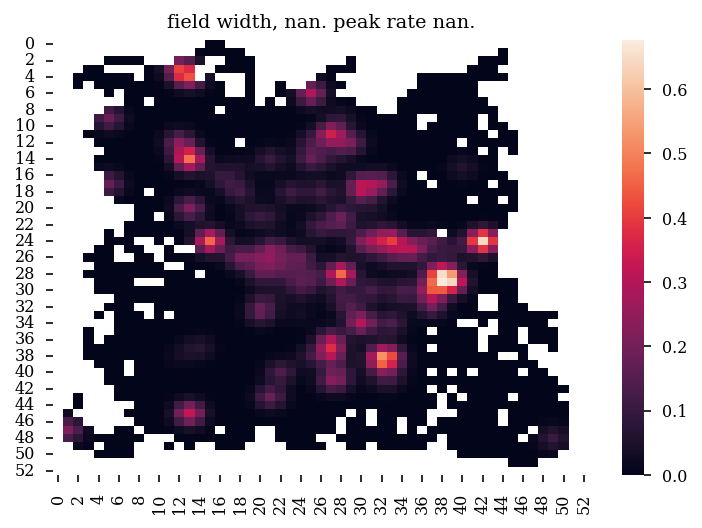

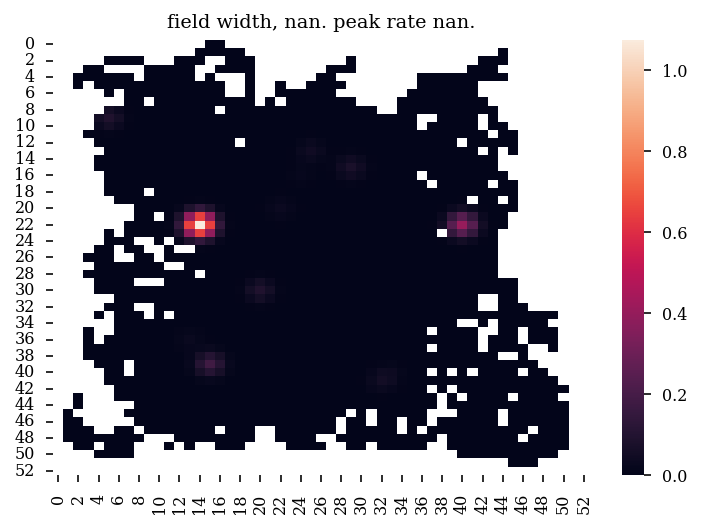

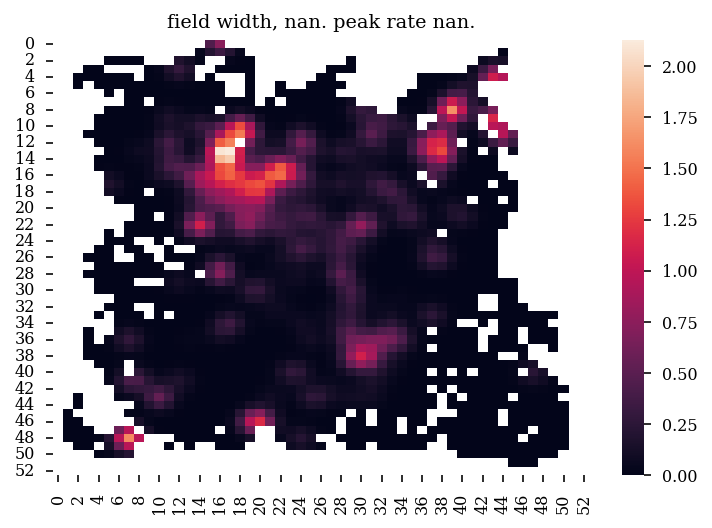

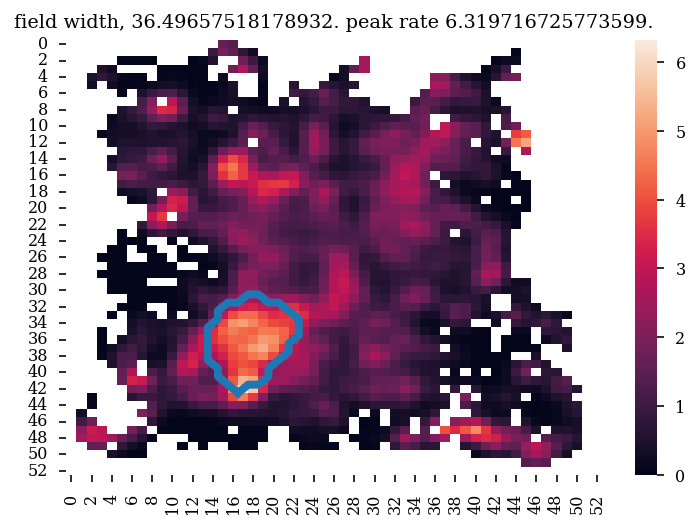

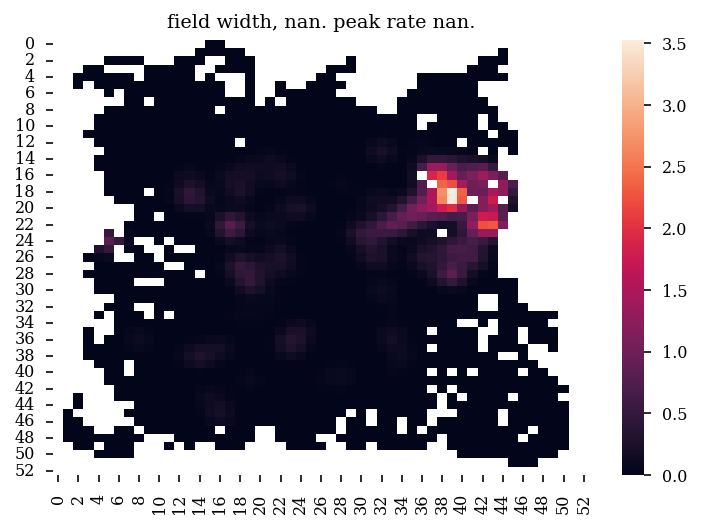

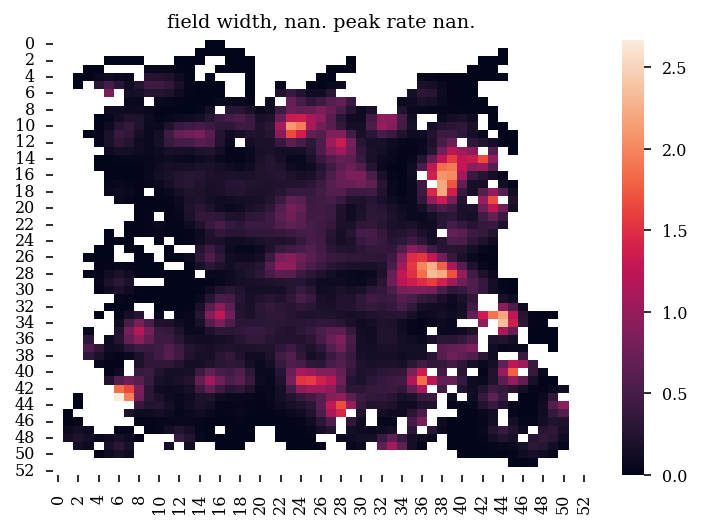

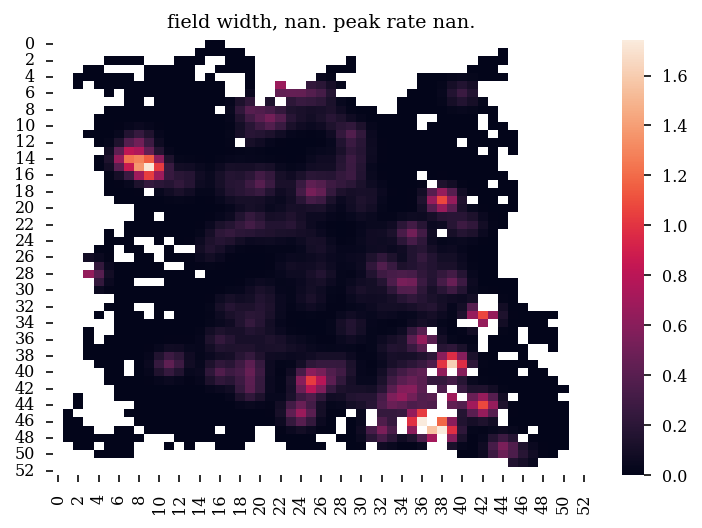

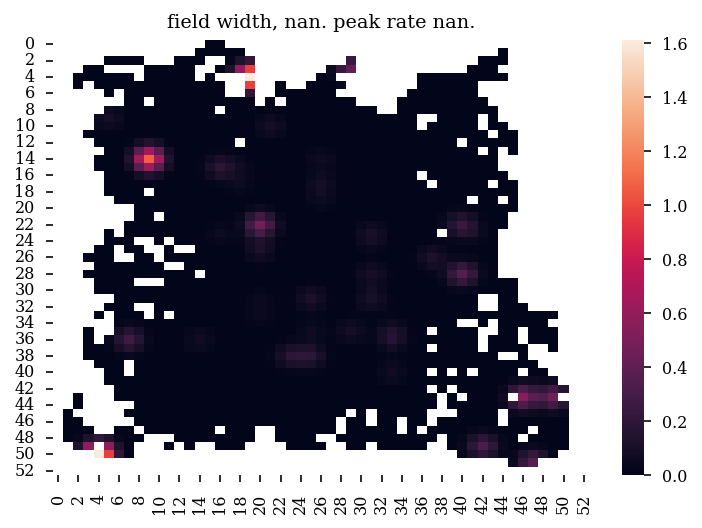

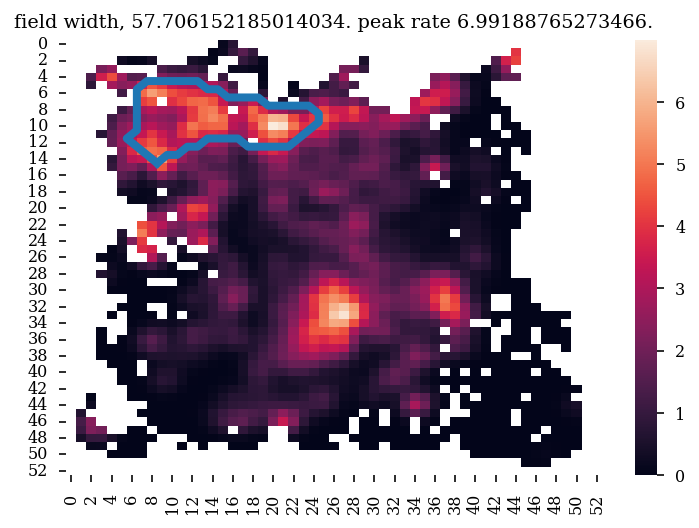

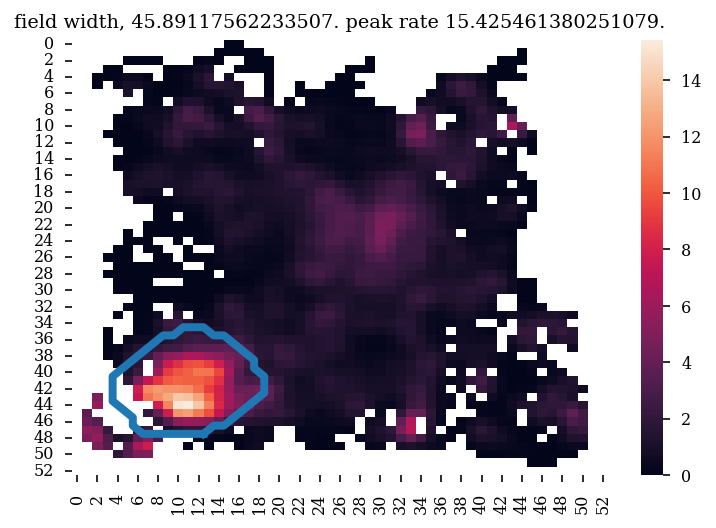

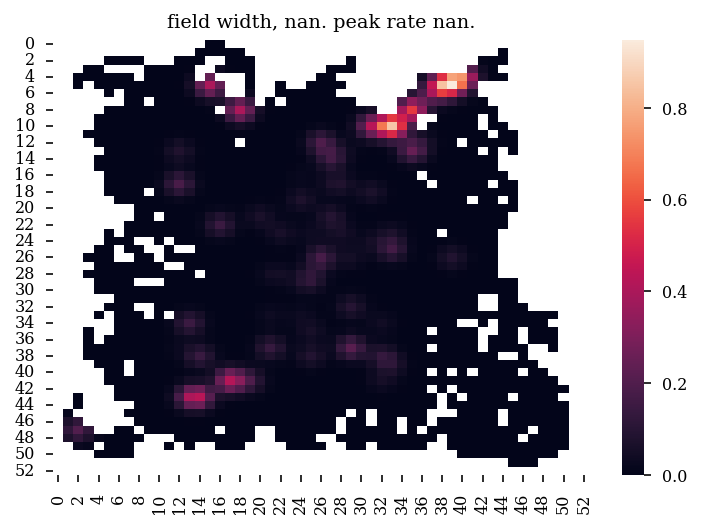

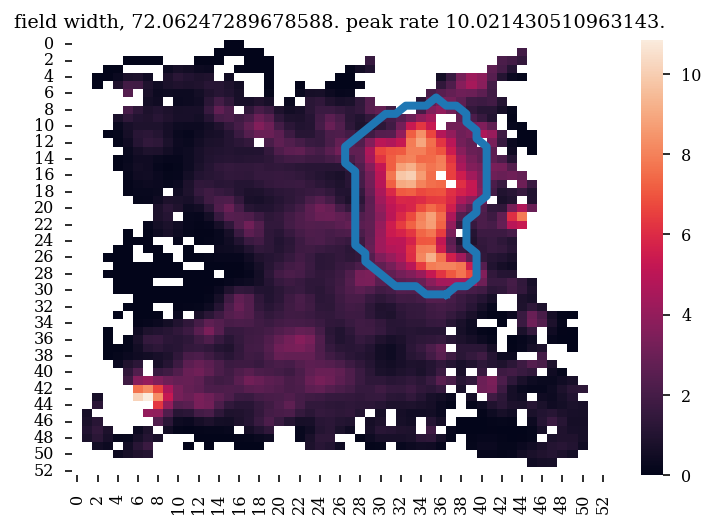

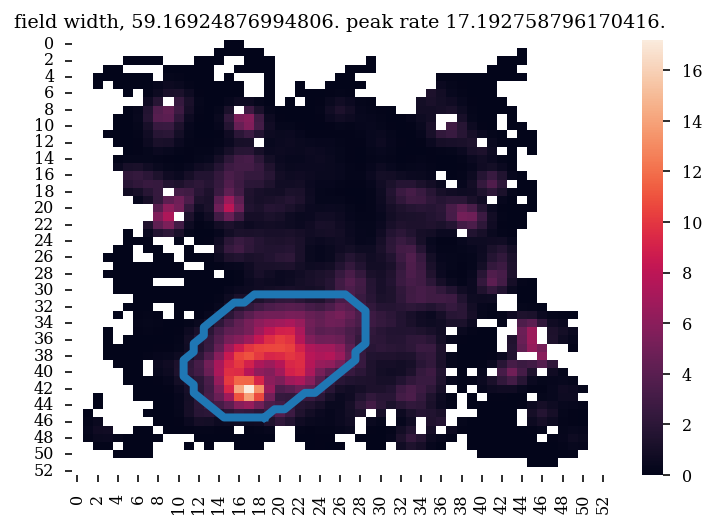

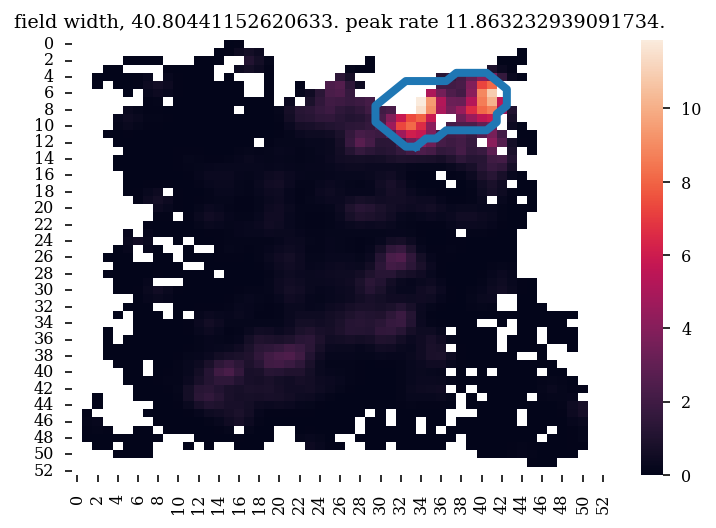

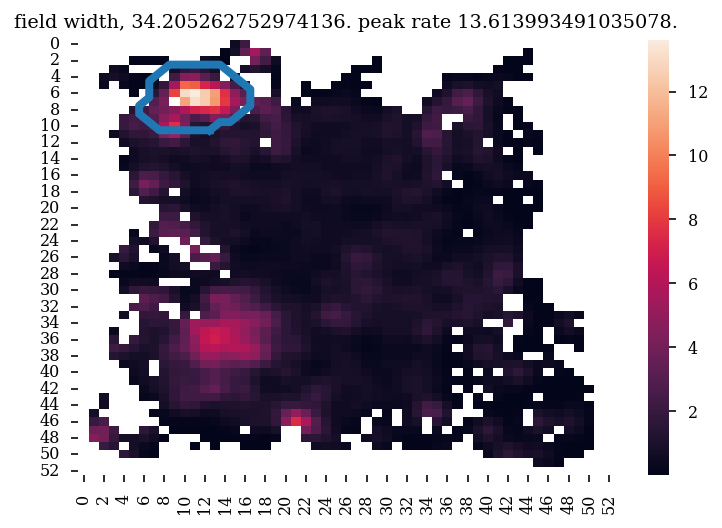

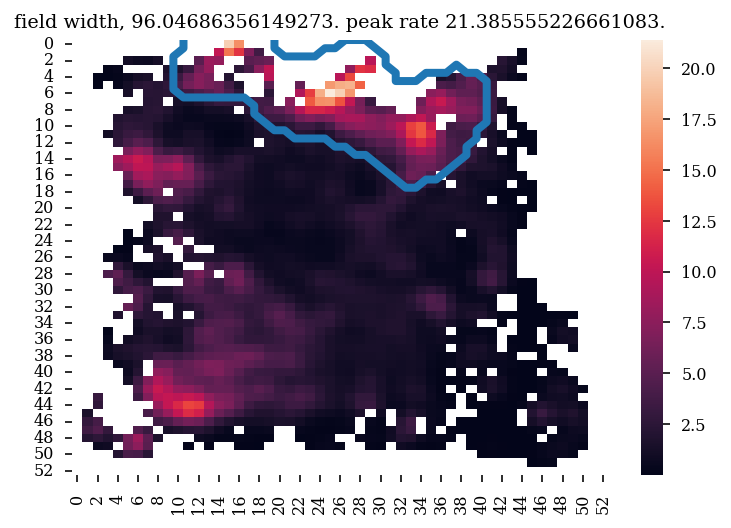

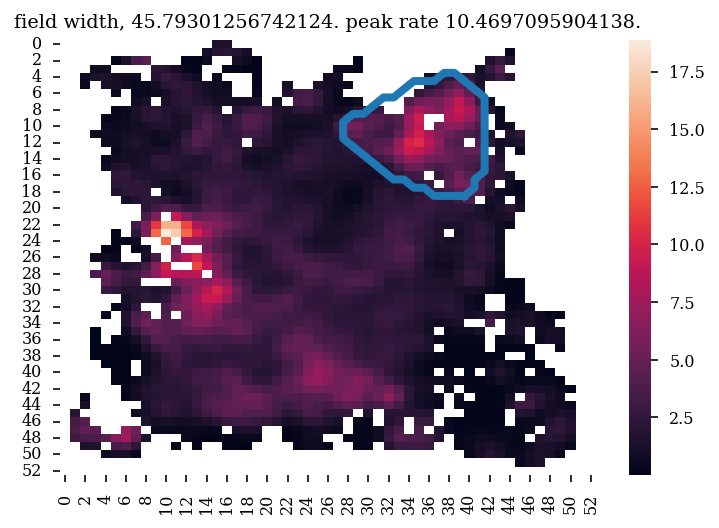

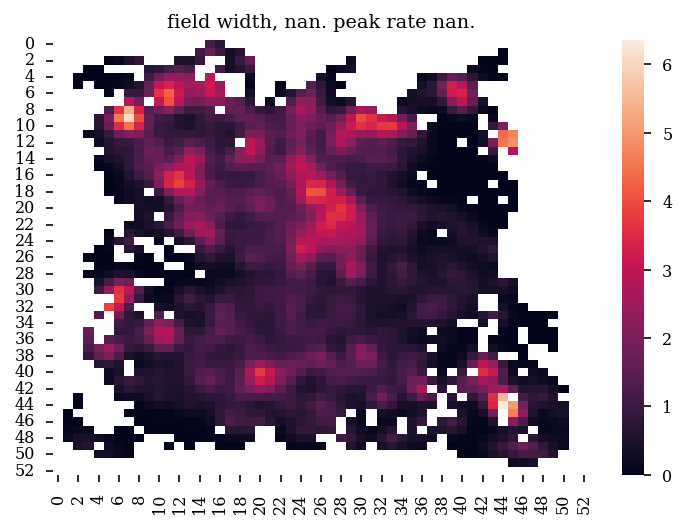

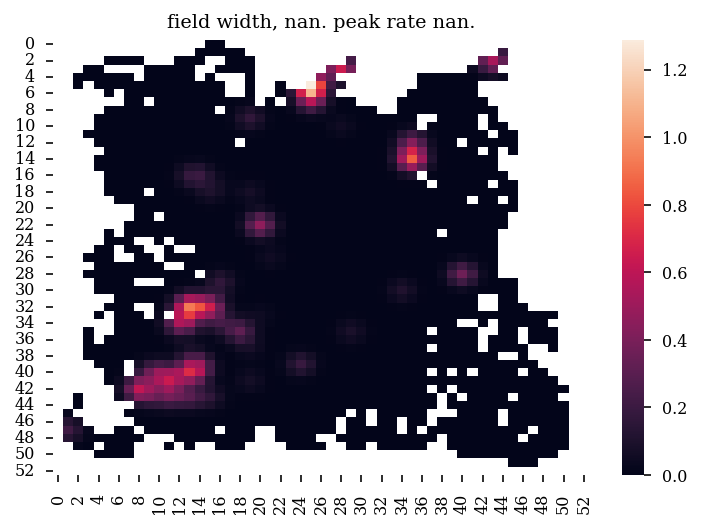

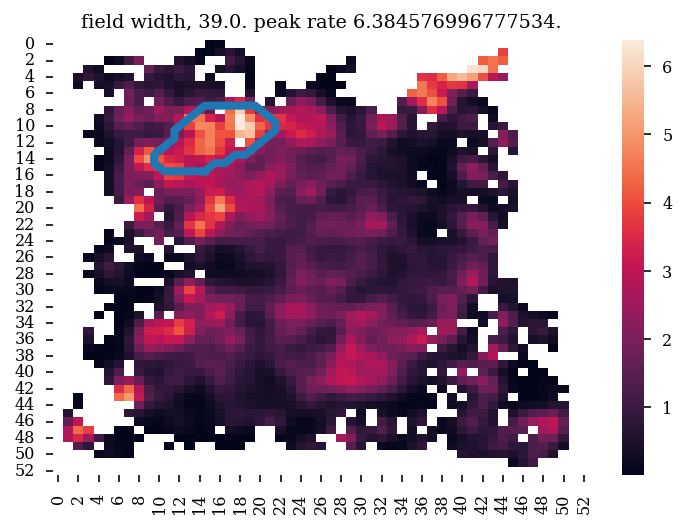

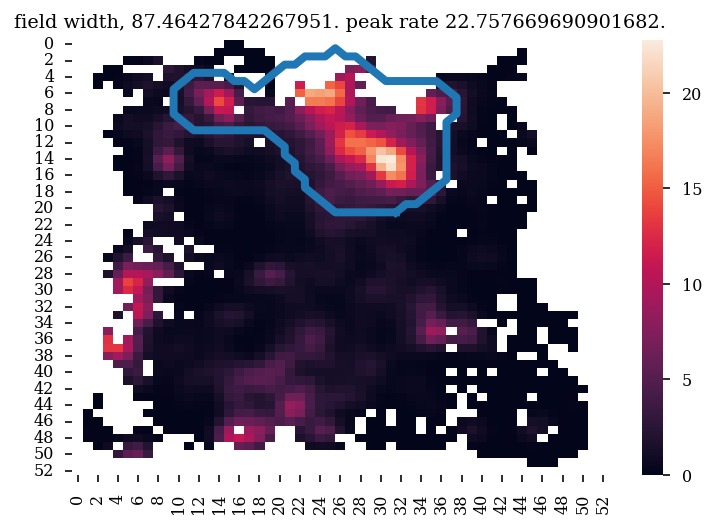

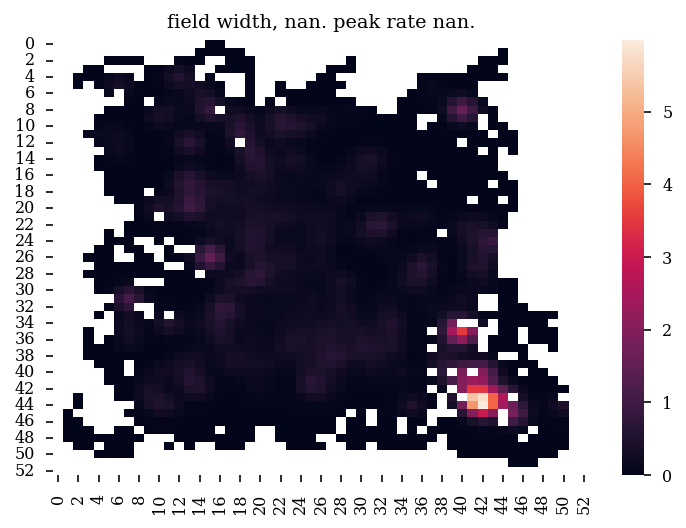

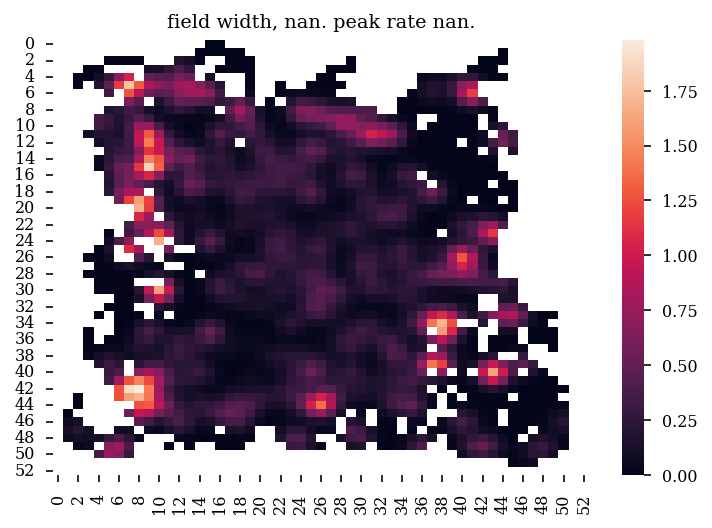

In [32]:
for ratemap_i, ratemap__ in enumerate(tc.tc.ratemap):
    ratemap_ = ratemap__.copy()
    ratemap_[tc.tc.occupancy < 0.01] = np.nan

    sns.heatmap(ratemap_)

    bc = measure.find_contours(tc.tc.field_mask[ratemap_i]==1, 0, fully_connected='low', positive_orientation='low')
    for c in bc:
        plt.plot(c[:, 1], c[:, 0],linewidth=4)
    plt.title(f"field width, {tc.tc.field_width[ratemap_i]}. peak rate {tc.tc.field_peak_rate[ratemap_i]}.")
    plt.show()

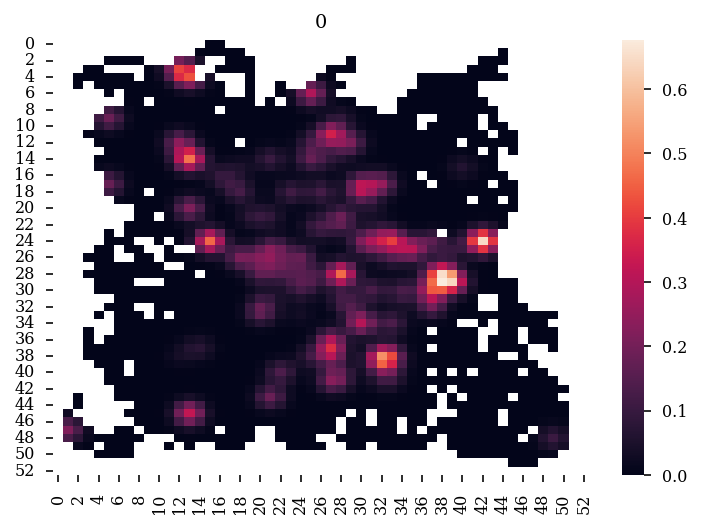

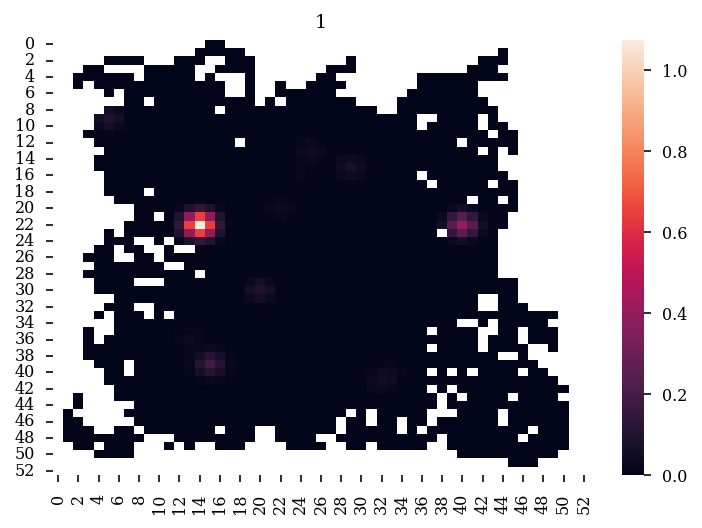

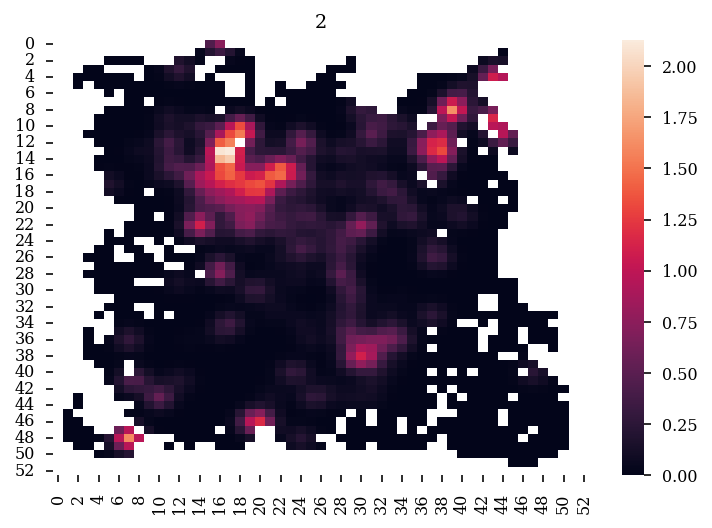

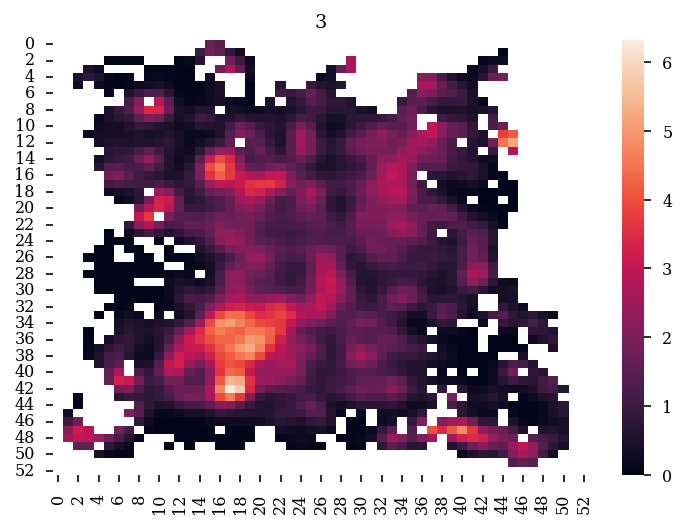

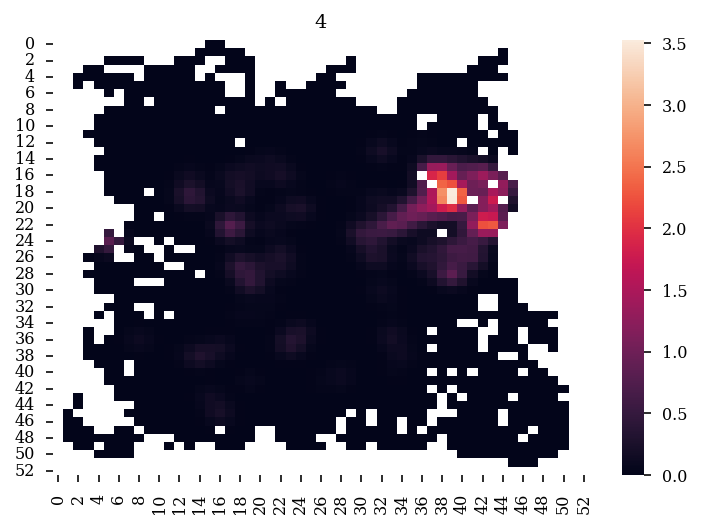

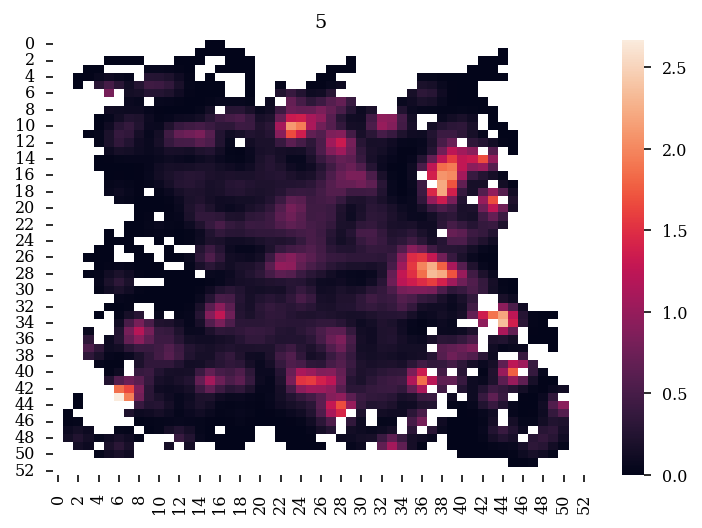

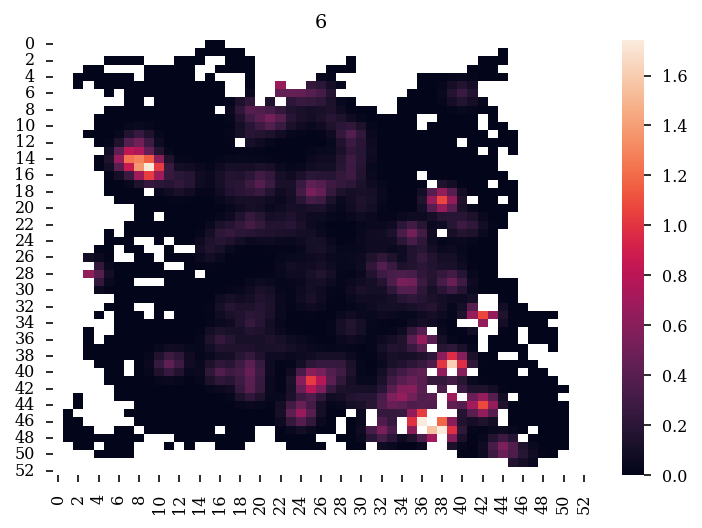

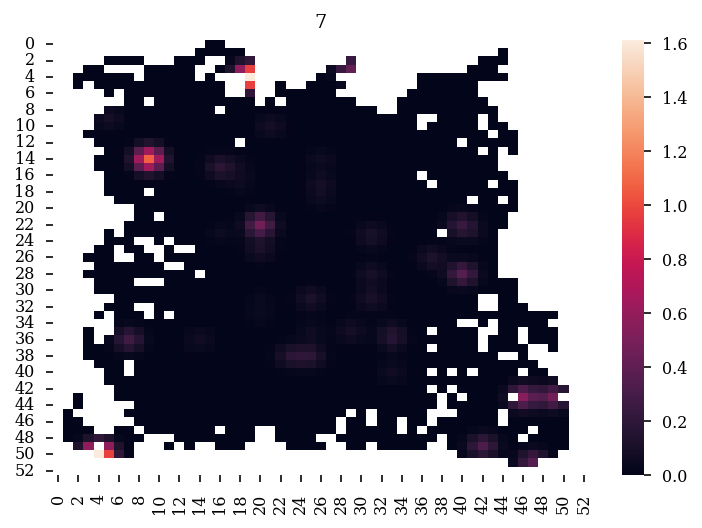

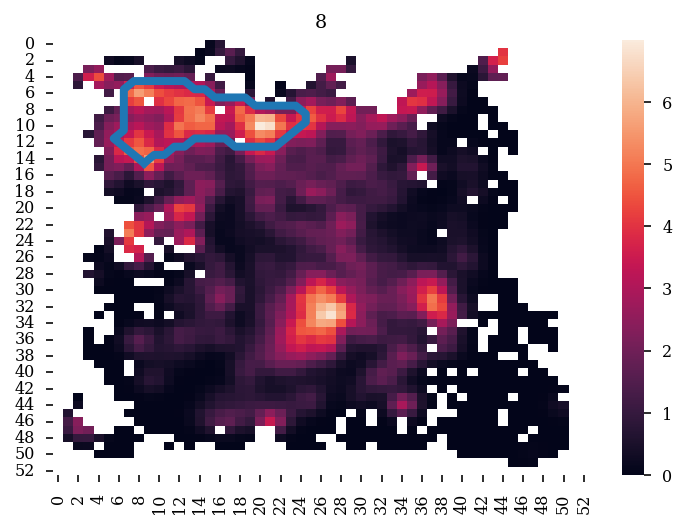

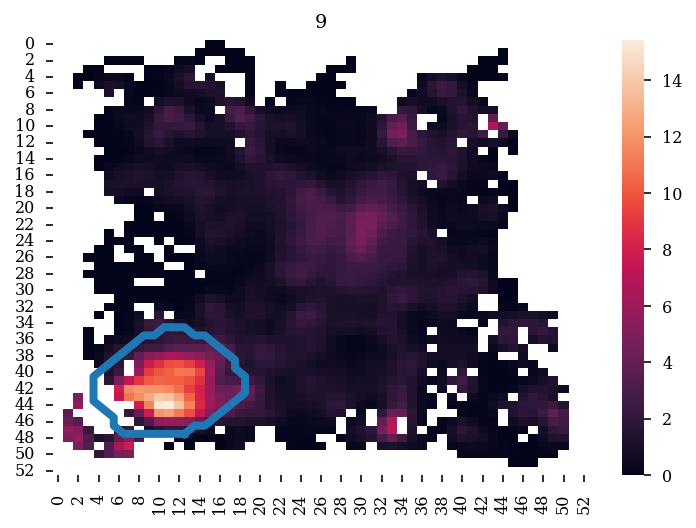

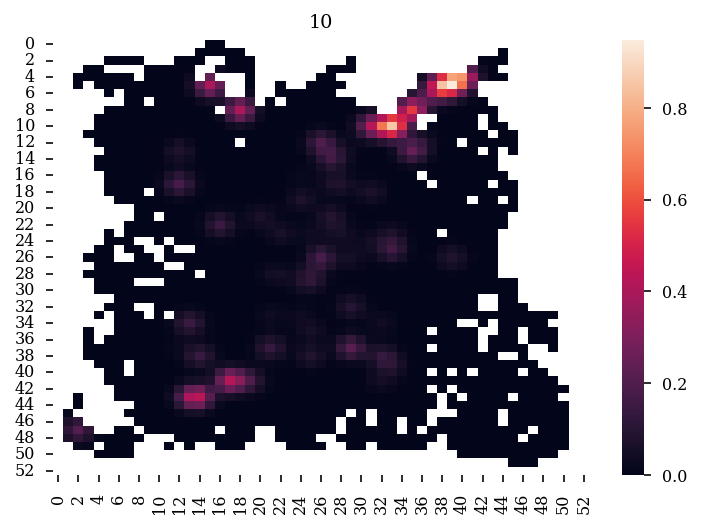

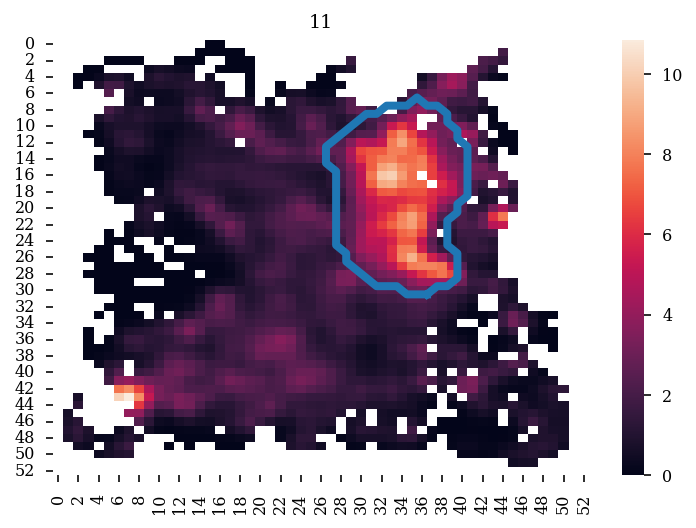

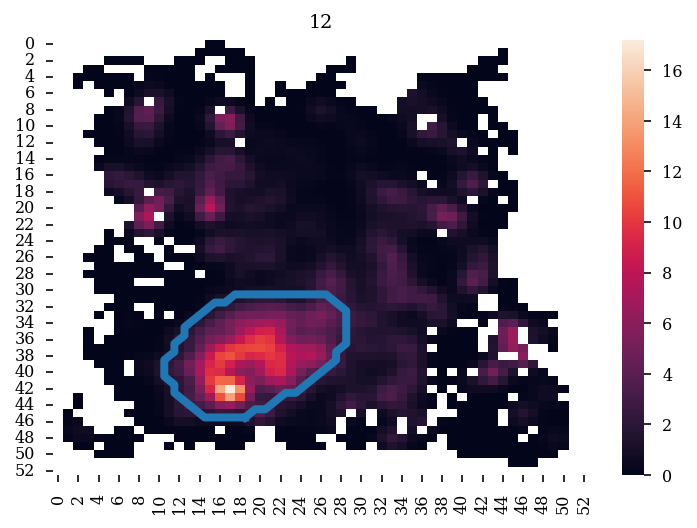

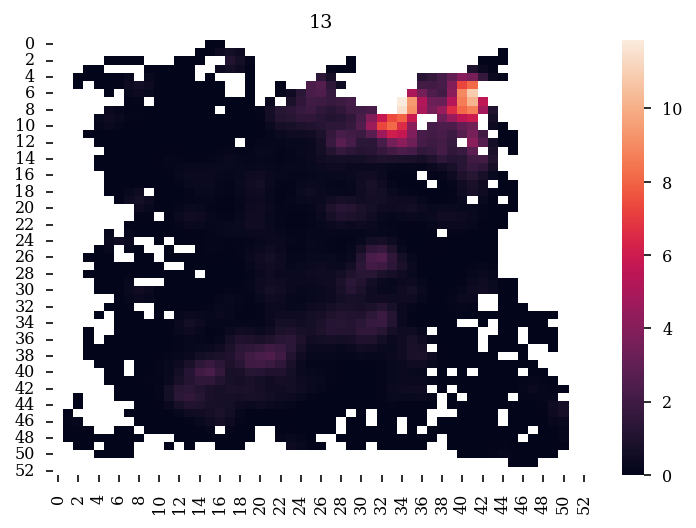

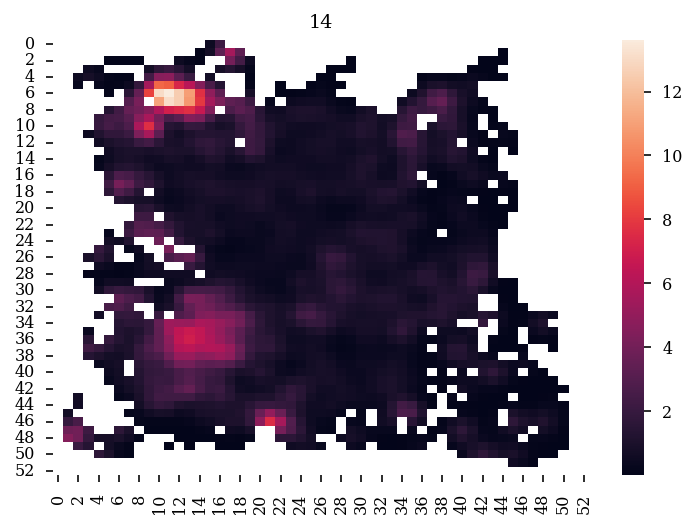

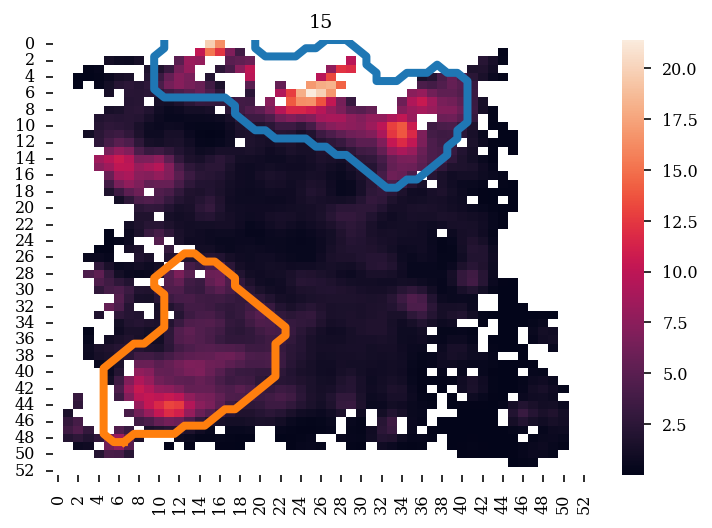

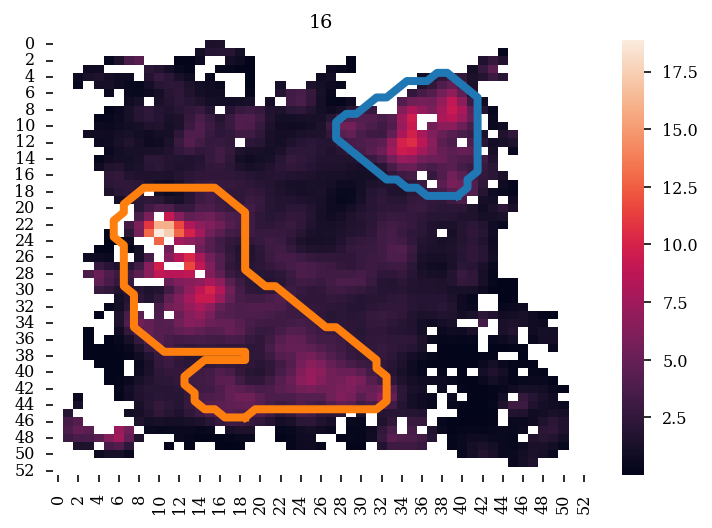

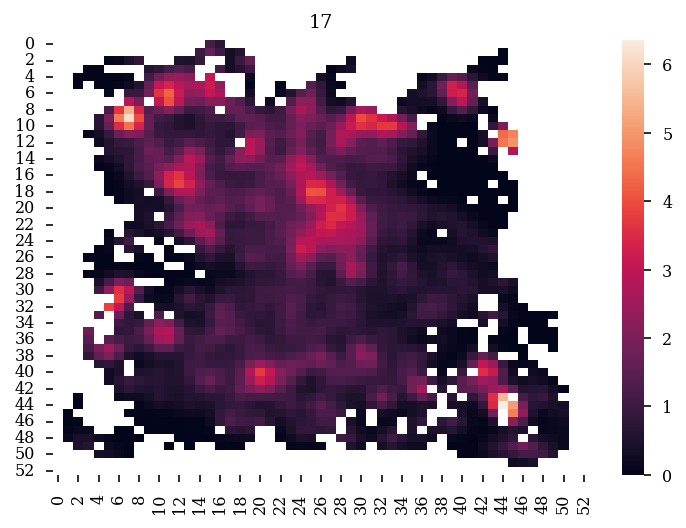

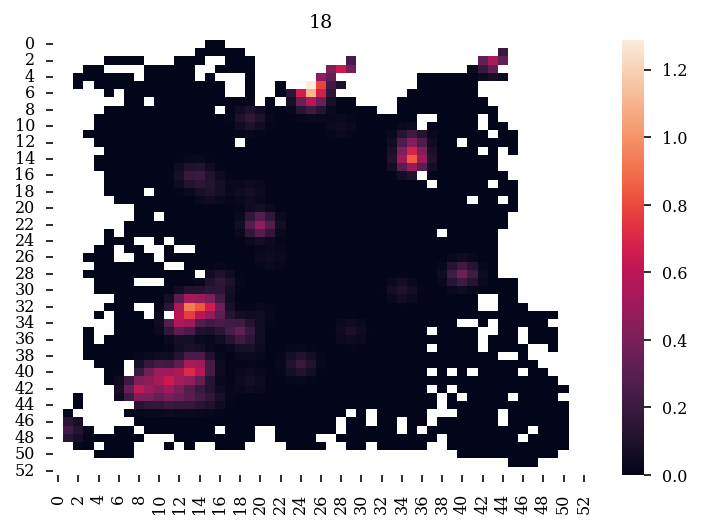

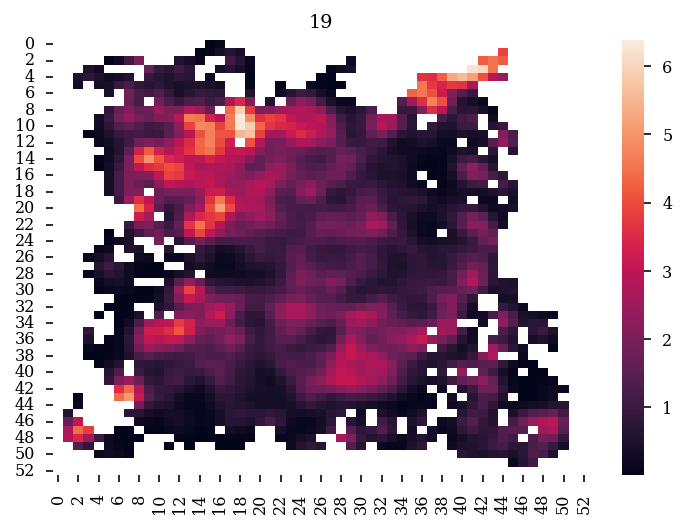

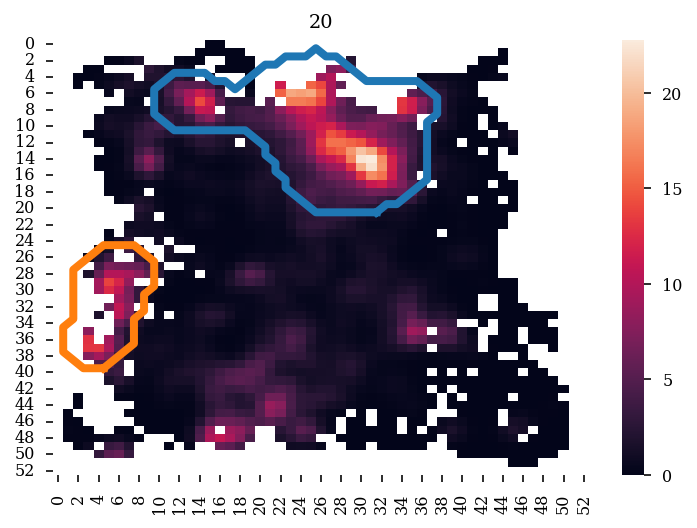

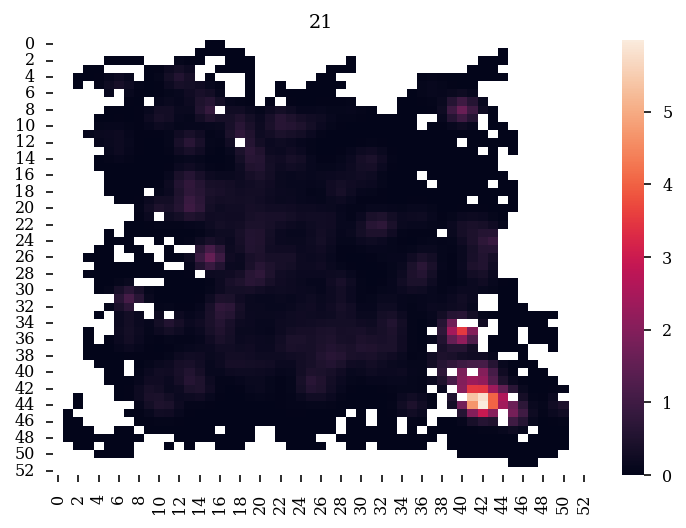

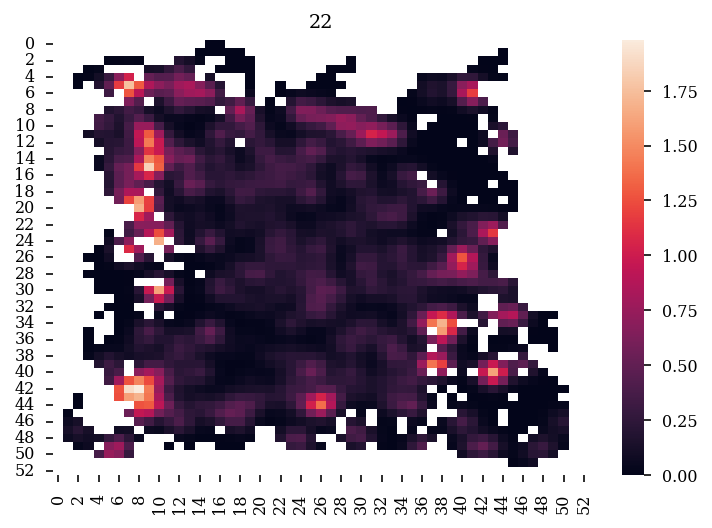

In [79]:
for ratemap_i, ratemap__ in enumerate(tc.tc.ratemap):
    ratemap_ = ratemap__.copy()
    ratemap_[tc.tc.occupancy < 0.01] = np.nan

    sns.heatmap(ratemap_)

    peaks = fields.compute_2d_place_fields(ratemap__, min_firing_rate=3, thresh=0.2,
                            min_size=80,sigma=2)

    bc = measure.find_contours(peaks, 0, fully_connected='low', positive_orientation='low')
    for c in bc:
        plt.plot(c[:, 1], c[:, 0],linewidth=4)

    plt.title(ratemap_i)
    plt.show()

In [102]:
# fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# ratemap_ = tc.tc.ratemap[11].copy()
# ratemap_[tc.tc.occupancy < 0.01] = np.nan

# sns.heatmap(ratemap_,ax=ax[0])
# ax[0].axis("equal")

# peaks = fields.separate_fields_by_laplace_of_gaussian(
#     np.array(tc.tc.ratemap[11]), sigma=5, minimum_field_area=120
# )
# sns.heatmap(peaks,ax=ax[1])
# plt.axis("equal")

# bc = fields.calculate_field_centers(
#     np.array(tc.tc.ratemap[11]), peaks, center_method="maxima"
# )
# # plt.imshow(peaks)
# for x, y in bc:
#     ax[0].scatter(x, y, color="blue")

# bc = measure.find_contours(peaks, 0, fully_connected='low', positive_orientation='low')
# for c in bc:
#     ax[0].plot(c[:, 1], c[:, 0],linewidth=4)

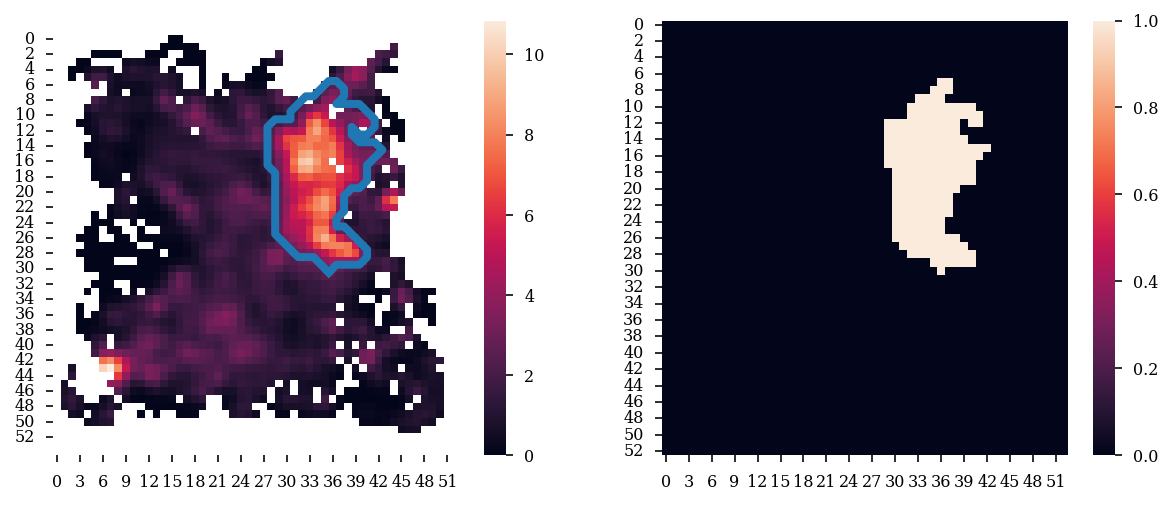

In [158]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ratemap_ = tc.tc.ratemap[11].copy()
ratemap_[tc.tc.occupancy < 0.01] = np.nan

sns.heatmap(ratemap_,ax=ax[0])
ax[0].axis("equal")

peaks = fields.compute_2d_place_fields(tc.tc.ratemap[11], min_firing_rate=3, thresh=0.2,
                            min_size=100)

sns.heatmap(peaks,ax=ax[1])

bc = measure.find_contours(peaks, 0, fully_connected='low', positive_orientation='low')
for c in bc:
    ax[0].plot(c[:, 1], c[:, 0],linewidth=4)

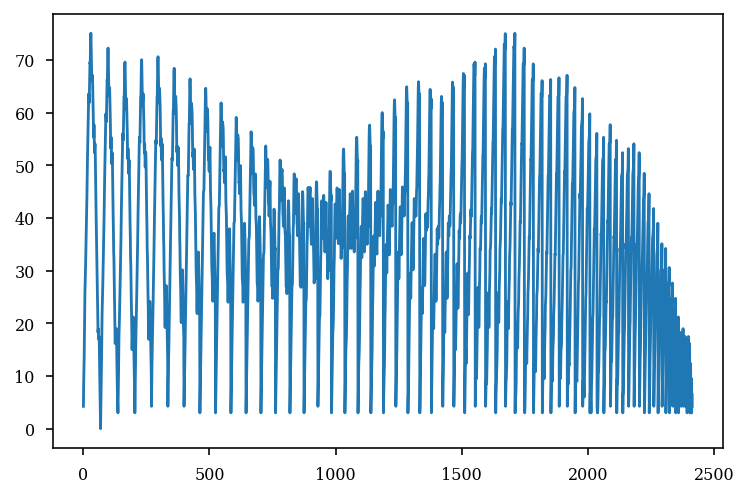

In [101]:
from scipy.spatial.distance import pdist
Y = pdist(bc[0], 'euclidean') * tc.s_binsize
plt.plot(Y)

In [125]:
is_place_field = fields.compute_linear_place_fields(tc.tc.ratemap[11][12], min_window_size=5,
                                min_firing_rate=3, thresh=0.2)
is_place_field

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False, False,
       False, False, False, False, False, False, False, False])

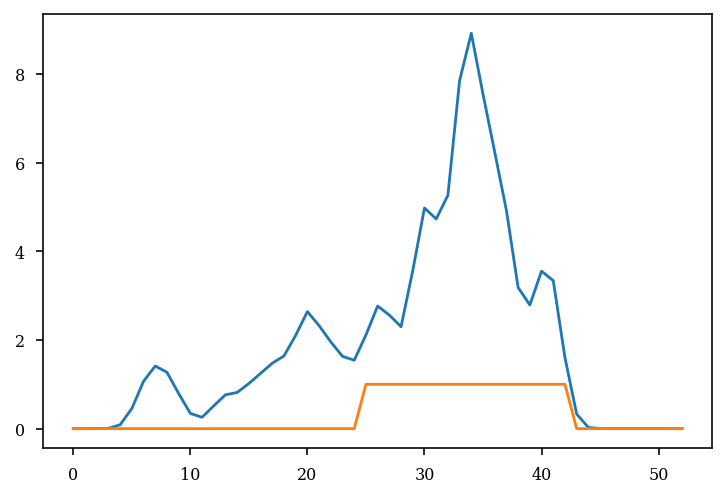

In [126]:
x = np.arange(len(tc.tc.ratemap[11][12]))
plt.plot(x,tc.tc.ratemap[11][12])
plt.plot(x,is_place_field)

# is_place_field

plt.show()

{'sizes': [0.45, 0.3],
 'peaks': [8.059808402766741, 3.770382743671043],
 'means': [5.215000412446764, 2.4201465757099068],
 'fields': array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])}

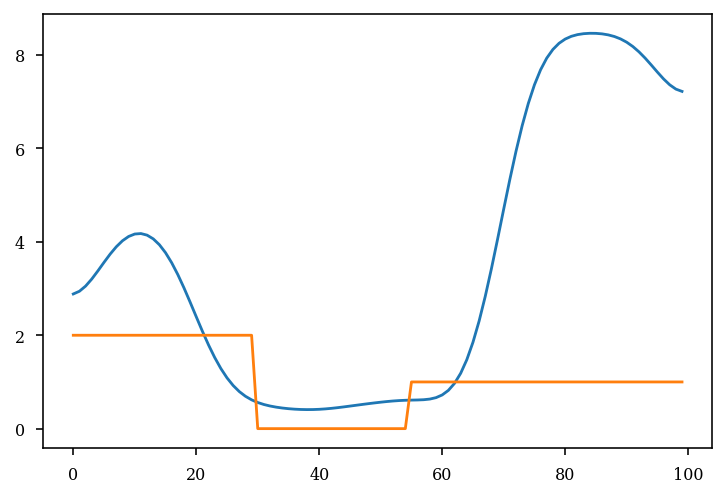

In [156]:
from scipy.ndimage import gaussian_filter1d
firing_rate = np.zeros(100)
firing_rate[3:20] = 4
firing_rate[70:99] = 8
firing_rate = firing_rate + np.random.rand(100)
firing_rate = gaussian_filter1d(firing_rate, 5)

x = np.arange(len(firing_rate))

plt.plot(x, firing_rate)

map_fields = fields.map_stats2(firing_rate, threshold=0.2, min_size=5, min_peak=3)

plt.plot(x, map_fields["fields"])

map_fields

In [135]:
fields.map_stats2(tc.tc.ratemap[11][12], threshold=0.2, min_size=5, min_peak=1.0)


{'sizes': [0.7358490566037735],
 'peaks': [8.915875370906694],
 'means': [2.661277086348221],
 'fields': array([0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])}

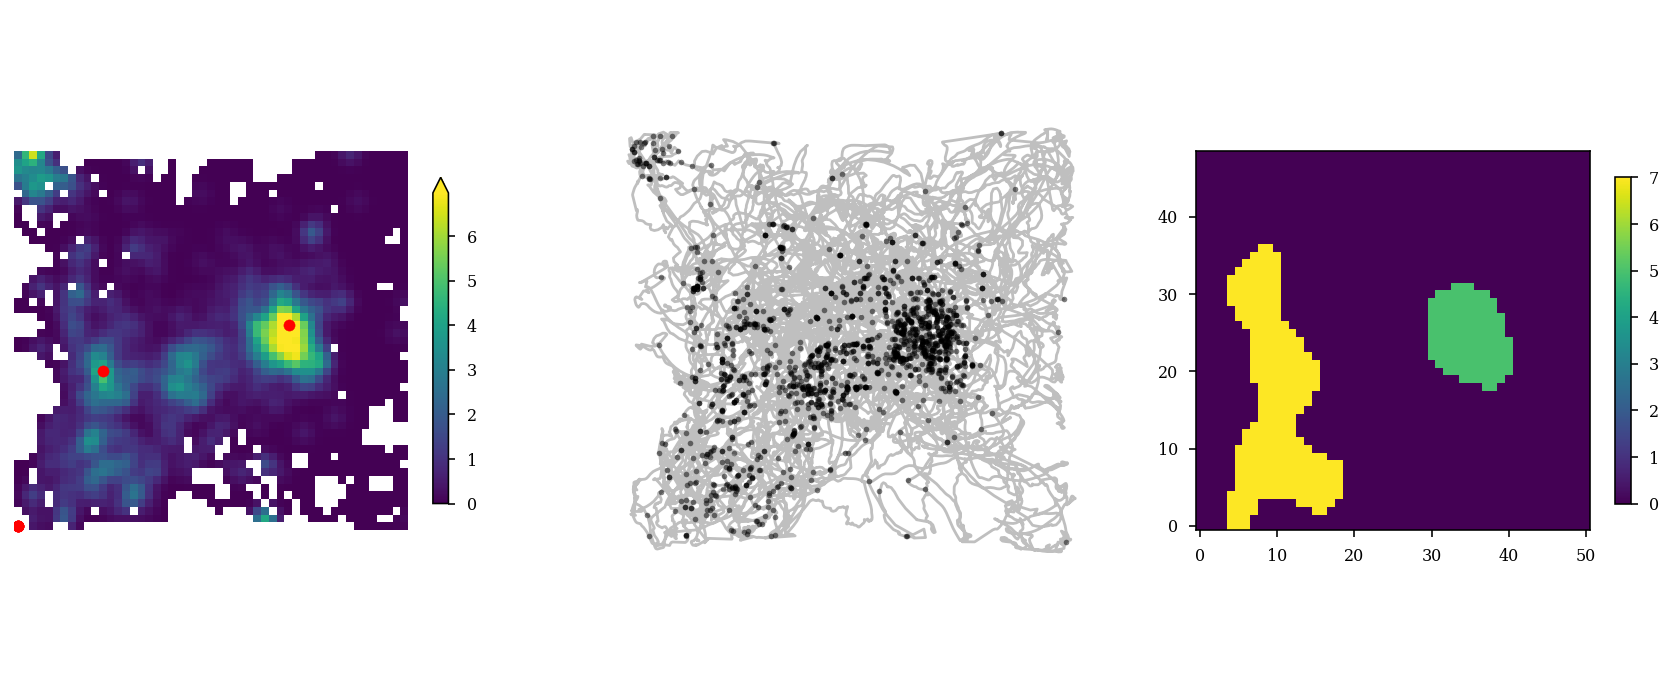

In [35]:
# plt.plot(results['x'][0], results['ts'][0])
# plt.show()
st = results["st"]
x = results["x"][0]
y = results["y"][0]
ts = results["ts"][0]
i = 7
fig, ax = plt.subplots(1, 3, figsize=(15, 6))

ratemap_ = results["ratemaps"][i].copy()
ratemap_[results["occupancies"][i] < 0.01] = np.nan
shw = ax[0].imshow(
    ratemap_, interpolation="nearest", origin="lower", vmax=np.nanmax(ratemap_) * 0.8
)
fig.colorbar(shw, ax=ax[0], extend="max", shrink=0.5)

ax[1].plot(x, y, color="grey", alpha=0.5)
ax[1].plot(
    np.interp(results["st"][i], ts, x),
    np.interp(results["st"][i], ts, y),
    ".k",
    alpha=0.5,
)
ax[1].axis("equal")
ax[1].axis("off")
ax[0].axis("equal")
ax[0].axis("off")

peaks = fields.separate_fields_by_laplace_of_gaussian(
    np.array(results["ratemaps"][i]), sigma=3, minimum_field_area=100
)
shw = ax[2].imshow(
    peaks, interpolation="nearest", origin="lower"
)
fig.colorbar(shw, ax=ax[2], shrink=0.5)

bc = fields.calculate_field_centers(
    np.array(results["ratemaps"][i]), peaks, center_method="maxima"
)
# plt.imshow(peaks)
for x, y in bc:
    ax[0].scatter(x, y, color="red")
# peaks = fields.find_peaks(ratemap_)
# peaks = separate_fields_by_laplace(ratemap_, threshold=0, minimum_field_area=None)
# for x,y in peaks:
#     ax[0].scatter(y,x,color='red')


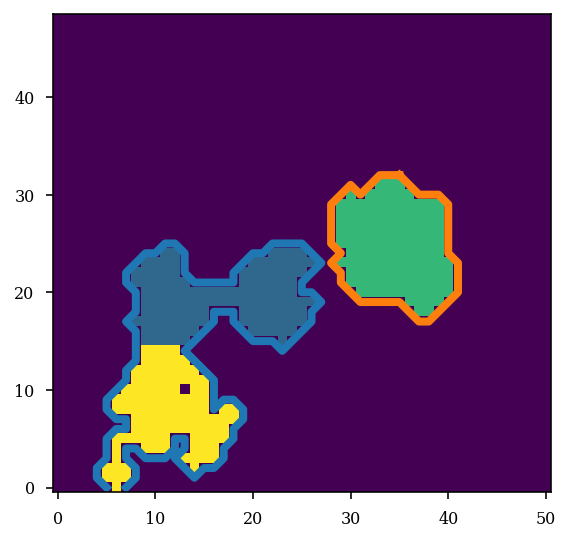

In [27]:
peaks = fields.compute_2d_place_fields(np.array(results["ratemaps"][i]), min_firing_rate=1, thresh=0.2,
                            min_size=100)
plt.imshow(peaks, interpolation="nearest", origin="lower")

bc = measure.find_contours(peaks, 0, fully_connected='low', positive_orientation='low')
for c in bc:
    plt.plot(c[:, 1], c[:, 0],linewidth=4)

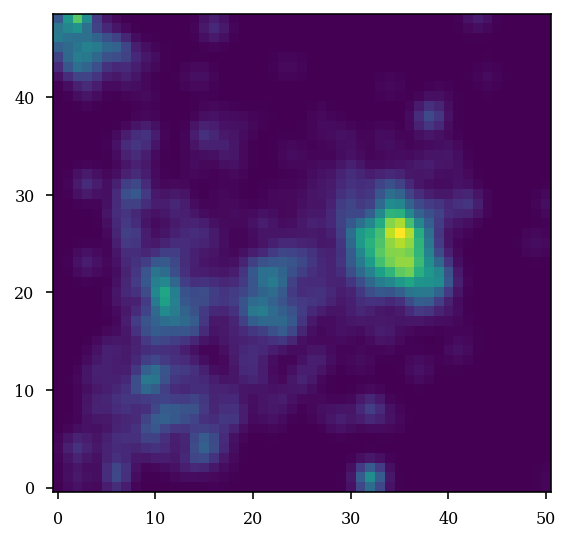

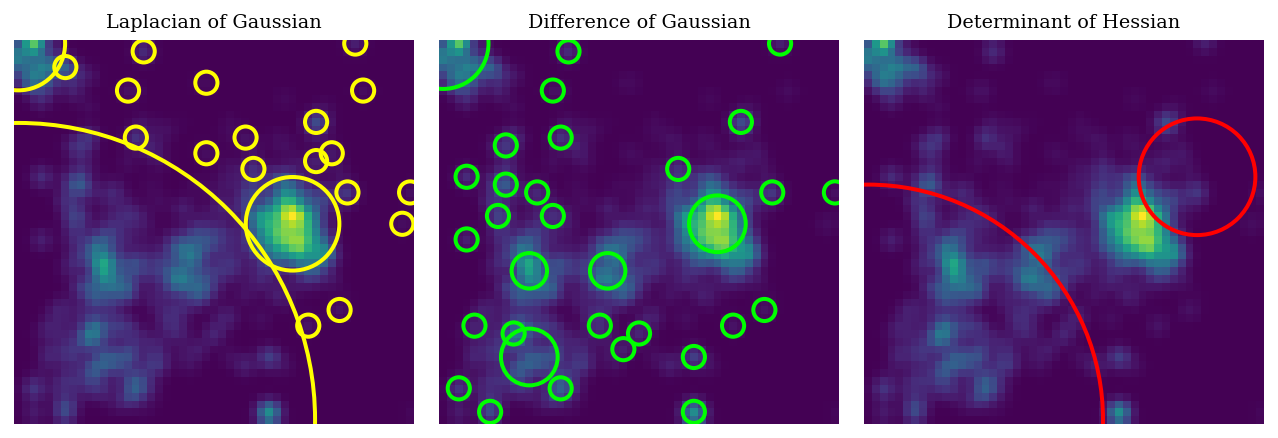

In [7]:
fields.detect_firing_fields(
    np.array(results["ratemaps"][i])
)


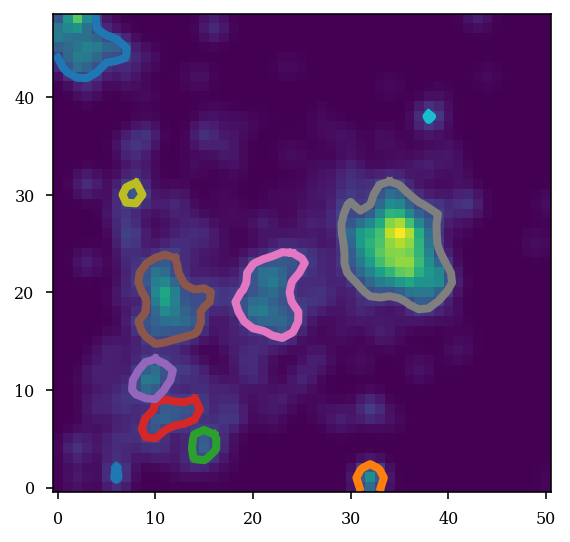

In [10]:
ratmap = np.array(results["ratemaps"][i])

plt.imshow(ratmap, interpolation="nearest", origin="lower")

# test = fields.sort_fields_by_rate(ratmap, ratmap>ratmap.max()*.2)
# plt.imshow(test, interpolation="nearest", origin="lower")

bc = measure.find_contours(ratmap, ratmap.max()*.2, fully_connected='low', positive_orientation='low')
for c in bc:
    plt.plot(c[:, 1], c[:, 0],linewidth=4)

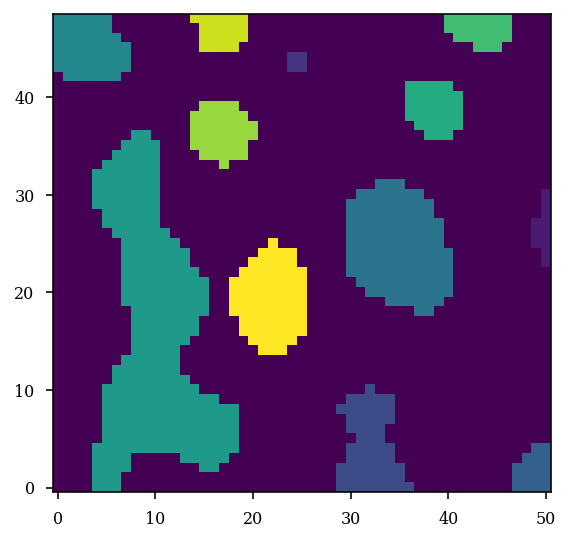

In [8]:
peaks = fields.separate_fields_by_laplace_of_gaussian(
    np.array(results["ratemaps"][i]), sigma=3
)
# peaks = fields.sort_fields_by_rate(np.array(results["ratemaps"][i]), peaks, np.max)

plt.imshow(peaks, interpolation="nearest", origin="lower")


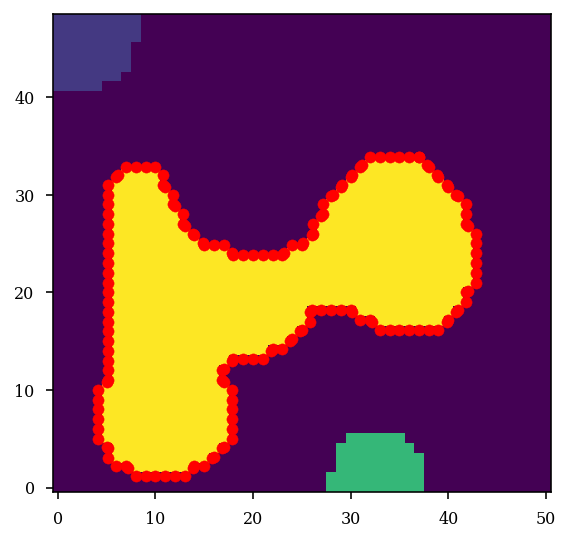

In [12]:
from skimage import measure
peaks = fields.separate_fields_by_laplace_of_gaussian(
    np.array(results["ratemaps"][i]), sigma=5, minimum_field_area=10
)

bc = measure.find_contours(peaks, 1, fully_connected='low', positive_orientation='low')

plt.imshow(peaks, interpolation="nearest", origin="lower")
for x, y in bc[-1]:
    plt.scatter(y, x, color="red")

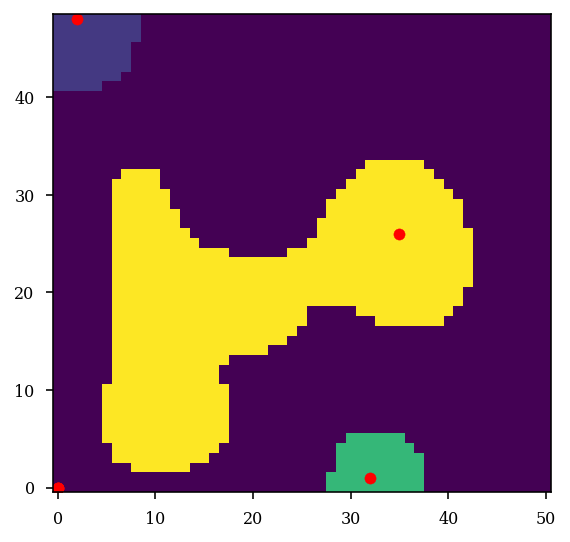

In [13]:
# peaks = fields.separate_fields_by_laplace(
#     np.array(results["ratemaps"][i]), threshold=.1, minimum_field_area=10
# )
# peaks = fields.separate_fields_by_dilation(
#     np.array(results["ratemaps"][i]), seed=2.5, sigma=4, minimum_field_area=10
# )
peaks = fields.separate_fields_by_laplace_of_gaussian(
    np.array(results["ratemaps"][i]), sigma=5, minimum_field_area=10
)
# peaks = fields.sort_fields_by_rate(np.array(results['ratemaps'][i]), peaks)
bc = fields.calculate_field_centers(
    np.array(results["ratemaps"][i]), peaks, center_method="maxima"
)
plt.imshow(peaks, interpolation="nearest", origin="lower")
for x, y in bc:
    plt.scatter(x, y, color="red")
